# Introduction

In this notebook, we begin by reviewing some of the basics of **probability** and **Bayes rule**, then make out way into **markov chains**, and **monte-carlo sampling**, combining them to give us **MCMC**, and then instate this in the **Gibbs Sampler**.

By the end, we will generate and understand the following animation:

![](gibbs.gif)

## Changelog
- 2023-02-24 - first published using quarto

## Animations

This notebook can (re)generate animations of optimization procedures, but that can take quite some time. In its place, you can use pre-generated GIFs/MP4s by togglnig this flag:

In [1]:
reanimate_gifs = False

## Notebook Setup

In [2]:
import numpy as np 
import sklearn
import sklearn.datasets
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

# for creating animations
import matplotlib.animation
from IPython.display import HTML, Video

In [3]:
# styling additions
from IPython.display import HTML
# style = "<style>div.warn{background-color: #fcf2f2;border-color: #dFb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;}</style>"
style = "<style>div.info{padding: 15px; border: 1px solid transparent; border-left: 5px solid #dfb5b4; border-color: transparent; margin-bottom: 10px; border-radius: 4px; background-color: #fcf8e3; border-color: #faebcc;}</style>"
HTML(style)

In [4]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [5]:
sblue,sorange,sgreen,sred = sns.color_palette()[0:4]

# Probability Review
Lets review the basics, by starting normally 😏

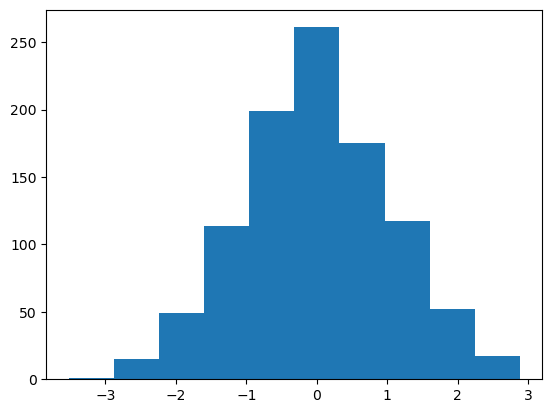

In [6]:
samples = np.random.standard_normal(1000)
plt.hist(samples);

Lets actually plot the **probability density function (PDF)**:

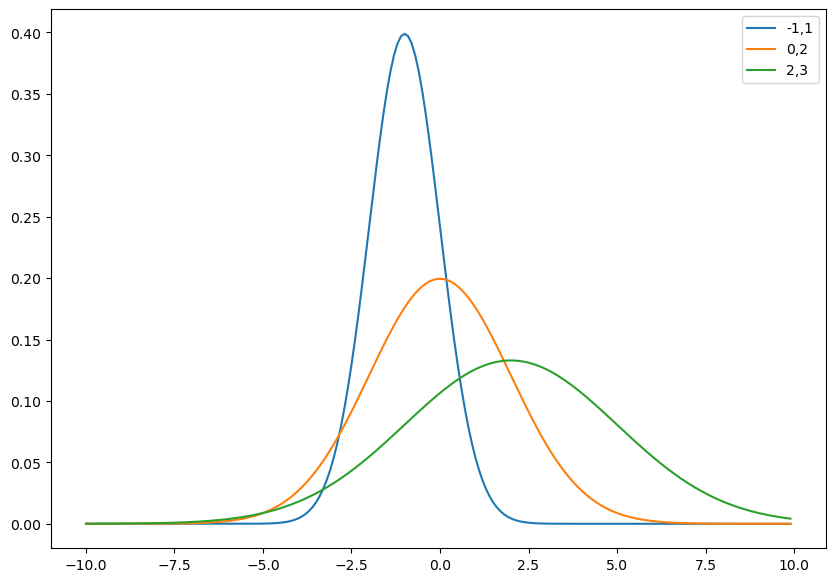

In [7]:
from scipy.stats import norm
rv = norm(loc = -1., scale = 1.0)
rv1 = norm(loc = 0., scale = 2.0)
rv2 = norm(loc = 2., scale = 3.0)

x = np.arange(-10, 10, .1)

plt.figure(figsize=(10,7))
plt.plot(x, rv.pdf(x), label='-1,1');
plt.plot(x, rv1.pdf(x), label='0,2');
plt.plot(x, rv2.pdf(x), label='2,3');
plt.legend();

Lets pick a **standard normal** and plot its PDF and its **cumulative distribution function (CDF)**

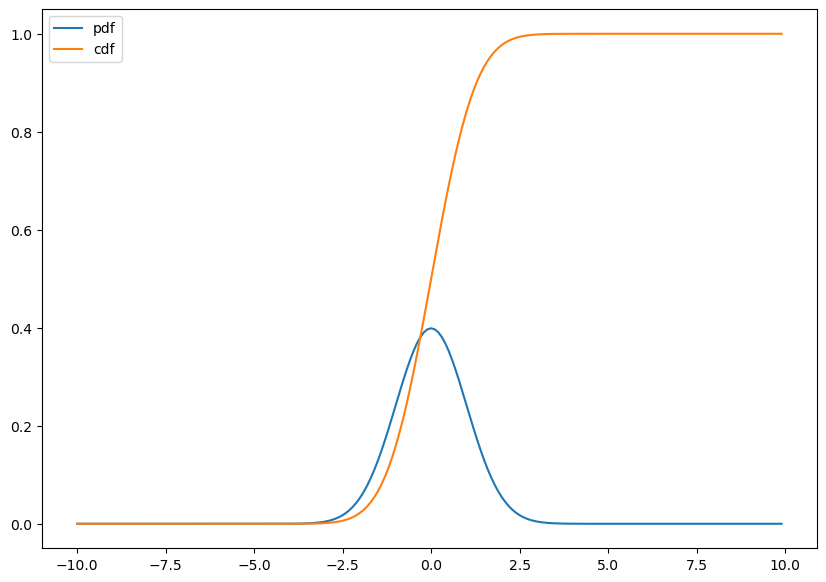

In [8]:
plt.figure(figsize=(10,7))
plt.plot(x,norm.pdf(x),color=sblue,label='pdf');
plt.plot(x,norm.cdf(x),color=sorange,label='cdf');
plt.legend();

Hm... Does this look familiar?

<div class="info">

<font size="6">🧐</font>**Pause-and-ponder**: What does this remind you of?

</div>

After a few minutes thought, you might recall the logistic function, and its derivative that we've been using in our neural network discussion! 

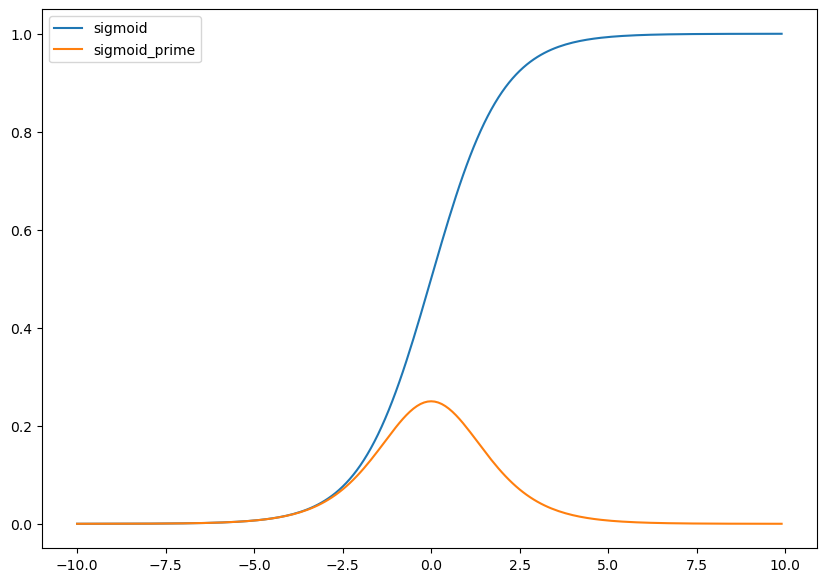

In [9]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

plt.figure(figsize=(10,7))
plt.plot(x,sigmoid(x),color=sblue,label='sigmoid');
plt.plot(x,sigmoid_prime(x),color=sorange,label='sigmoid_prime');
plt.legend();

Hm. Lets plot them together and see!! 

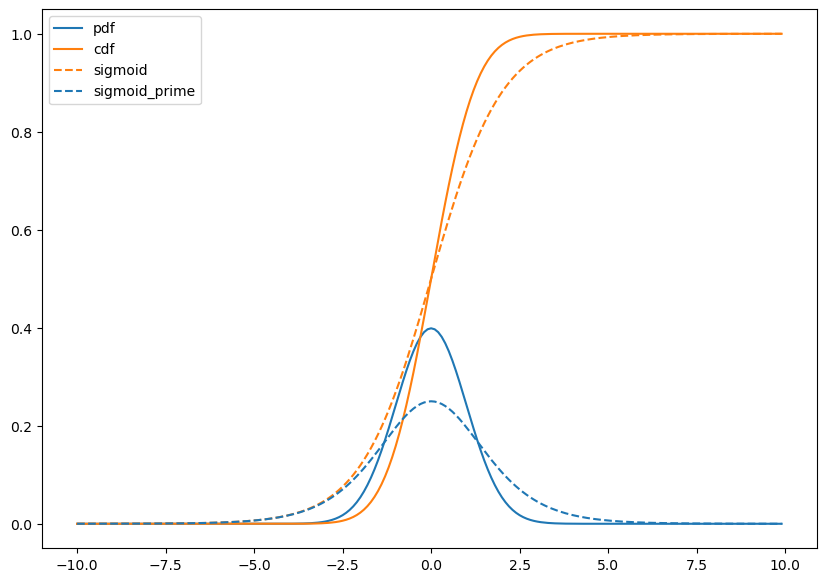

In [10]:
plt.figure(figsize=(10,7))
plt.plot(x,norm.pdf(x),color=sblue,label='pdf');
plt.plot(x,norm.cdf(x),color=sorange,label='cdf');
plt.plot(x,sigmoid(x),color=sorange,linestyle='--',label='sigmoid');
plt.plot(x,sigmoid_prime(x),color=sblue,linestyle='--',label='sigmoid_prime');
plt.legend();

<div class="info">

<font size="6">🧐</font>**Pause-and-ponder**: What can you say about this plot?

</div>

Hm. Maybe something non obvious is going on here, so its worth thinking about this for a second, and reminding ourselves of the definitions.

<div class="info">

<font size="6">📖 </font>**Semi-Definition**: A **cumulative distribution function (CDF)** is (almost) any **monotonically increasing** function whose range is $(0,1)$, describing the probability of a random variable $X$ being less than a specific value $x$:
    
$$
F_X (x) = P(X \leq x)
$$

</div>

**Note:** We aren't being that careful in our definition (continuity, etc., etc.), but it serves us well enough to illustrate our purposes.

**Note:** Monotonically increasing is a fancy way to say **not decreasing.**

With this definition in mind, lets revisit the plot of the normal CDF:

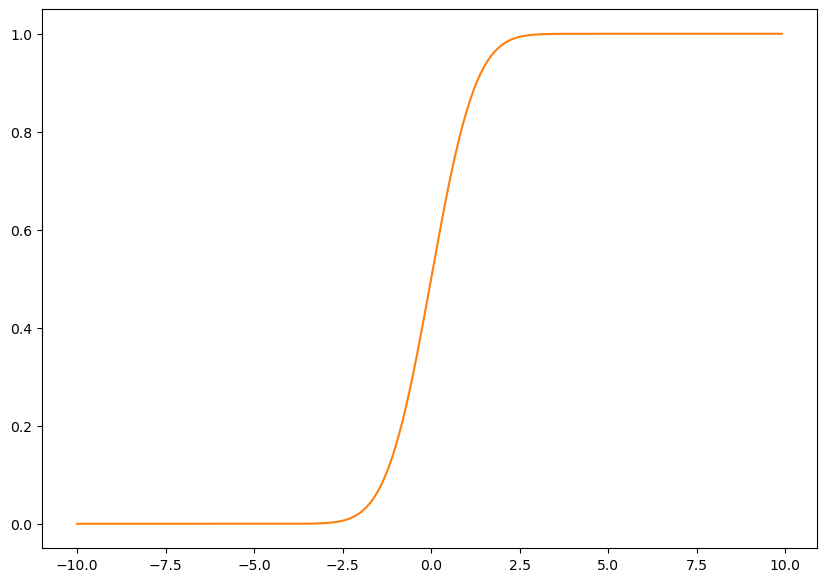

In [11]:
plt.figure(figsize=(10,7))
plt.plot(x,norm.cdf(x),color=sorange,label='cdf');

Ok, so what is $F(0)$? Its $P(X<0)$, and we can see that this function tells us that its 0.5! Lets verify:

In [12]:
norm.cdf(0)

0.5

Ah. What about the sigmoid?

In [13]:
sigmoid(0)

0.5

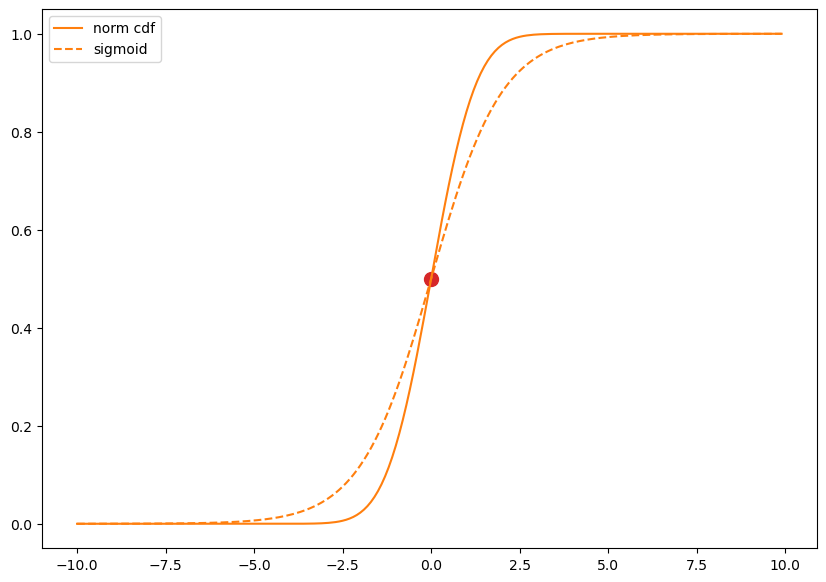

In [14]:
plt.figure(figsize=(10,7))
plt.plot(x,norm.cdf(x),color=sorange,label='norm cdf');
plt.plot(x,sigmoid(x),color=sorange,linestyle='--',label='sigmoid');
plt.scatter(0,norm.cdf(0),color=sred,s=100)
plt.legend();

Interesting. So they both agree on this point, but clearly, they don't agree everywhere! 

Wait. **So are we saying that the logistic function is also a CDF?**

Yes! Indeed it is! 

Well, then we can use this to leap towards the following question: 

If `sigmoid` is the CDF, then what is `sigmoid_prime`? 

Well by our graph above, it sure looks a lot like a Gaussian density/PDF! 

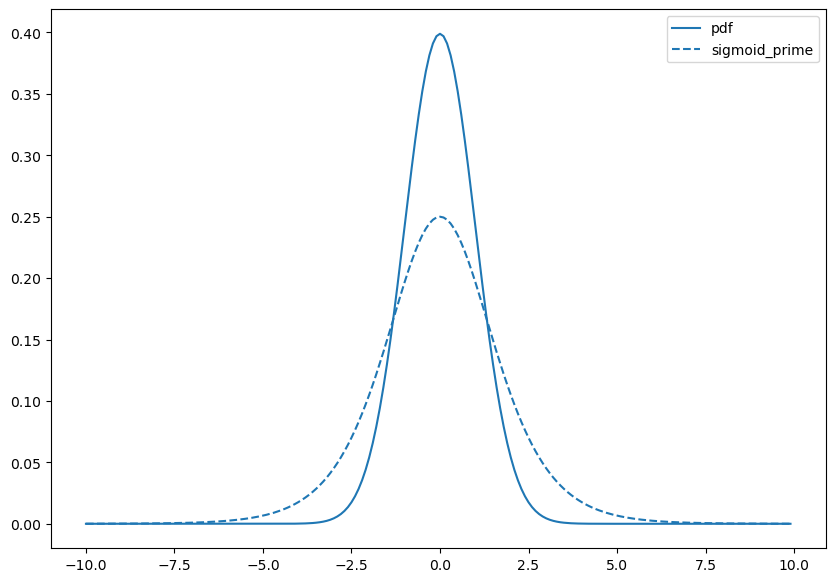

In [15]:
plt.figure(figsize=(10,7))
plt.plot(x,norm.pdf(x),color=sblue,label='pdf');
plt.plot(x,sigmoid_prime(x),color=sblue,linestyle='--',label='sigmoid_prime');
plt.legend();

Indeed it is! `sigmoid_prime` is a PDF! So we have "discovered" the following relationship between CDFs and PDFs:


<div class="info">

<font size="6">📖 </font>**Semi-Definition**: A **probability density function (PDF)** is the **derivative** of a CDF:

$$
f_X(x) = \frac{d}{dx}F_X(x)
$$

Accordingly, the probability of $X$ falling within a range $(a,b)$ is given by:

$$
P(a \leq X \leq b) = \int_a^b f_X(x) dx
$$
    
</div>

It should be easy to see then that:

$$
P(-\infty \leq X \leq x) = \int_{-\infty}^{x} f_X(u)du = F_X(x)
$$

<div class="info">

<font size="6">🧐 </font>**Note**: There is **much** more we can say here about PDFs vs PMFs. For example:

 * how they are **not** the same thing
 * how the prob of a continuous RV taking on a specific point is 0.
 * inverse CDFs, and inverse transform sampling
 * etc. 
    
Keep these technicalities in your mind, though we will freely be jumping between continuous and discrete RVs in our treatment since you've all already had a formal probability class.
    
</div>

## Thinking about the tails

Ok, so whats the difference between the gaussian density and the logistic density? 

**Its all in the tails**.

This is a **fantastic thinking tool** to keep in mind when you're thinking about the behavior of distributions/probabilistic objects. 

In order to aid this kind of thinking, we will do something very common in probability. Instead of thinking of them *directly*, we will think about **log-probabilities**.

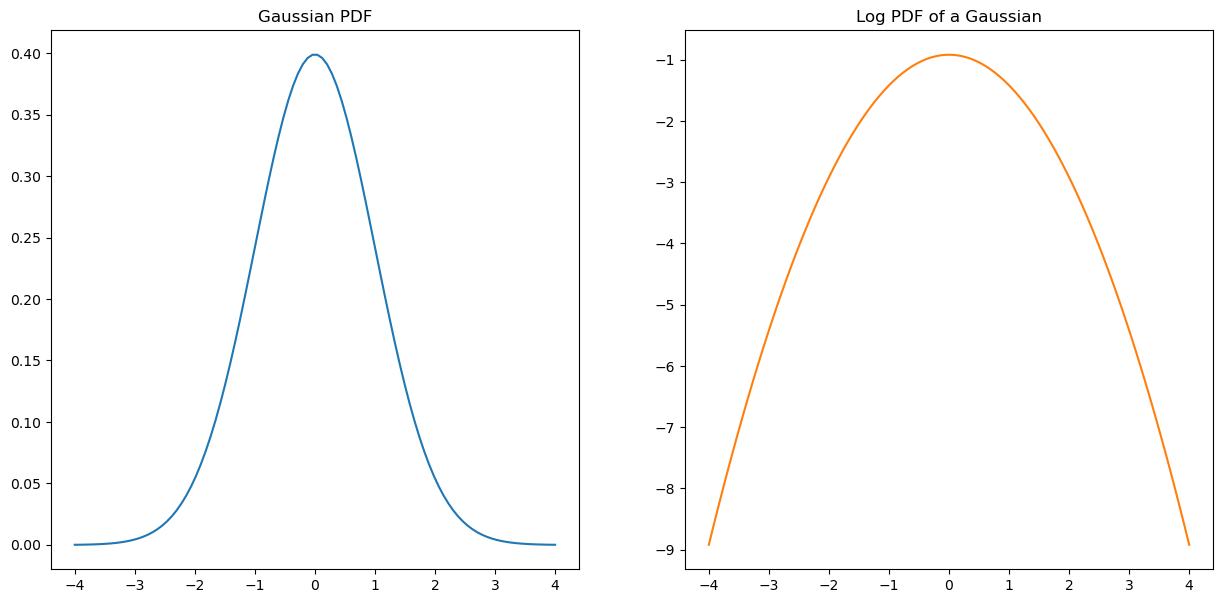

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
x = np.linspace(-4,4,100)
ax1.plot(x,norm.pdf(x));
ax1.set_title('Gaussian PDF')
ax2.plot(x,norm.logpdf(x),color=sorange);
ax2.set_title('Log PDF of a Gaussian');

<div class="info">

<font size="6">🧐 </font>**Pause-and-ponder**: Does the shape of this make sense? Why or why not?
    
</div>

Lets compare this to the logistic density we gave above:

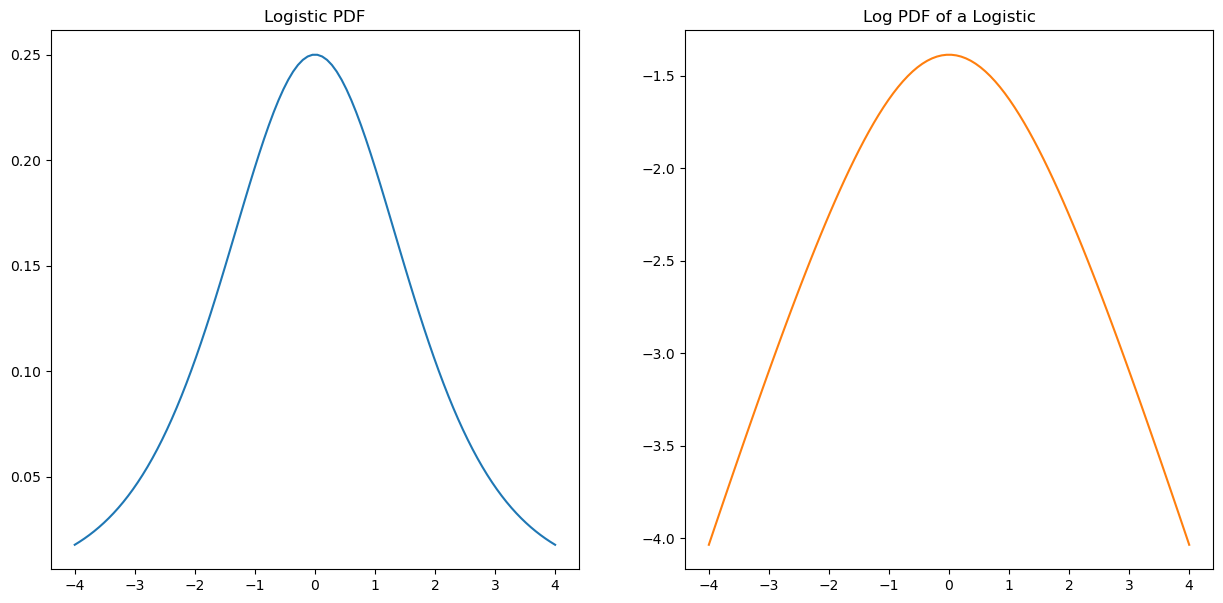

In [17]:
from scipy.stats import logistic
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
x = np.linspace(-4,4,100)
ax1.plot(x,logistic.pdf(x));
ax1.set_title('Logistic PDF')
ax2.plot(x,logistic.logpdf(x),color=sorange);
ax2.set_title('Log PDF of a Logistic');

Hm. Lets plot them together to get a better idea, and add in a **cauchy** distribution:

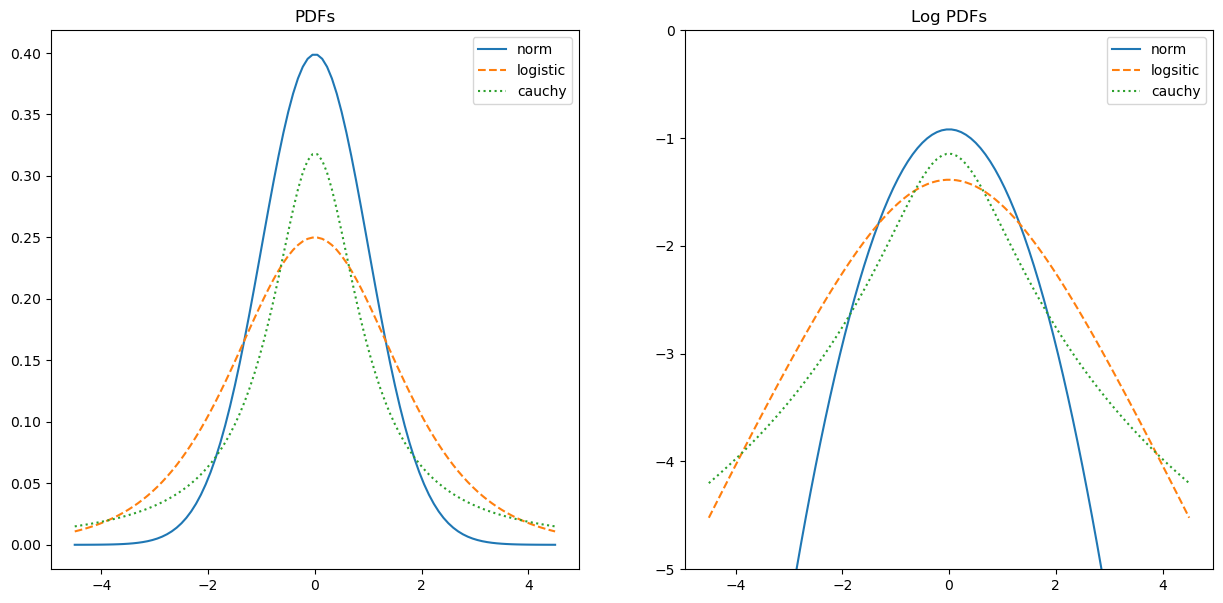

In [18]:
from scipy.stats import logistic
from scipy.stats import cauchy
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
x = np.linspace(-4.5,4.5,100)
ax1.plot(x,norm.pdf(x),label='norm');
ax1.plot(x,logistic.pdf(x),linestyle='--',label='logistic');
ax1.plot(x,cauchy.pdf(x),linestyle=':',label='cauchy');
ax1.set_title('PDFs')
ax1.legend();

ax2.plot(x,norm.logpdf(x),label='norm');
ax2.plot(x,logistic.logpdf(x),linestyle='--',label='logsitic');
ax2.plot(x,cauchy.logpdf(x),linestyle=':',label='cauchy');
ax2.set_title('Log PDFs');
ax2.set_ylim([-5,0]);
ax2.legend();

Play around with the graph above, and lets discuss what we observe:

# The Log

Lets look a bit deeper into the log:

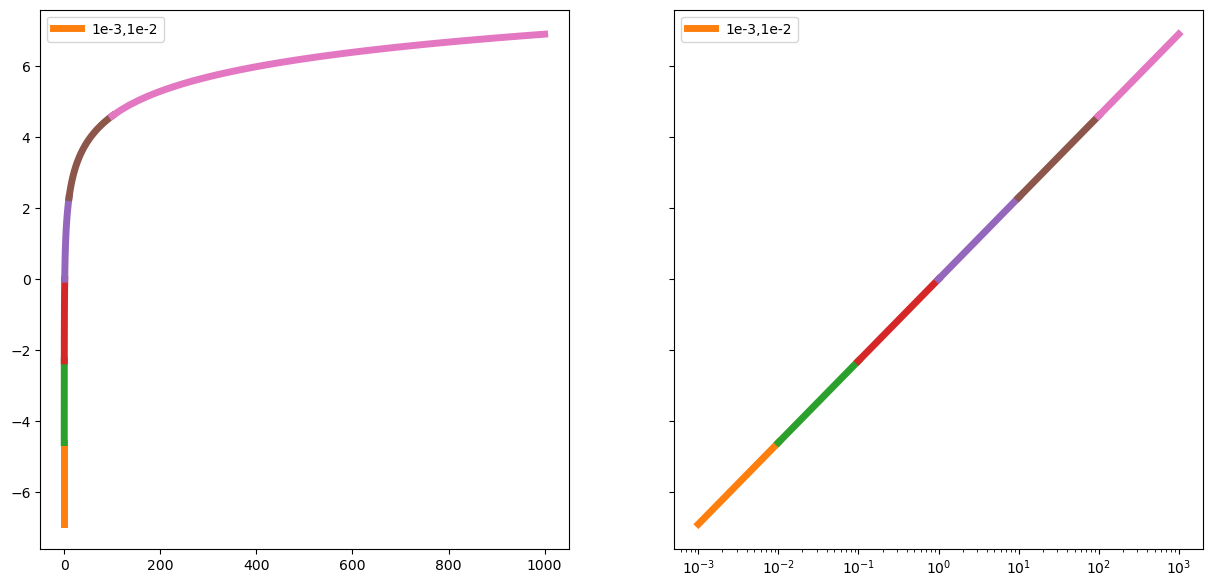

In [19]:
x = np.linspace(1e-3,1e3,1000)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,7),sharey=True)
ax1.plot(x,np.log(x))
ax2.set_xscale('log')
ax2.plot(x,np.log(x));

xs=np.linspace(1e-3,1e-2);ax2.plot(xs,np.log(xs),linewidth=5,label='1e-3,1e-2');ax2.legend();ax1.plot(xs,np.log(xs),linewidth=5,label='1e-3,1e-2');ax1.legend()
xs=np.linspace(1e-2,1e-1);ax2.plot(xs,np.log(xs),linewidth=5);ax1.plot(xs,np.log(xs),linewidth=5);
xs=np.linspace(1e-1,1);ax2.plot(xs,np.log(xs),linewidth=5);ax1.plot(xs,np.log(xs),linewidth=5);
xs=np.linspace(1,10);ax2.plot(xs,np.log(xs),linewidth=5);ax1.plot(xs,np.log(xs),linewidth=5);
xs=np.linspace(10,1e2);ax2.plot(xs,np.log(xs),linewidth=5);ax1.plot(xs,np.log(xs),linewidth=5);
xs=np.linspace(1e2,1e3);ax2.plot(xs,np.log(xs),linewidth=5);ax1.plot(xs,np.log(xs),linewidth=5);

The distance between `0.000001` and `0.0000001` is as **big as the distance between `100` and `1000`**. Or the distance between `00000000000.1` and `000000000000.1`

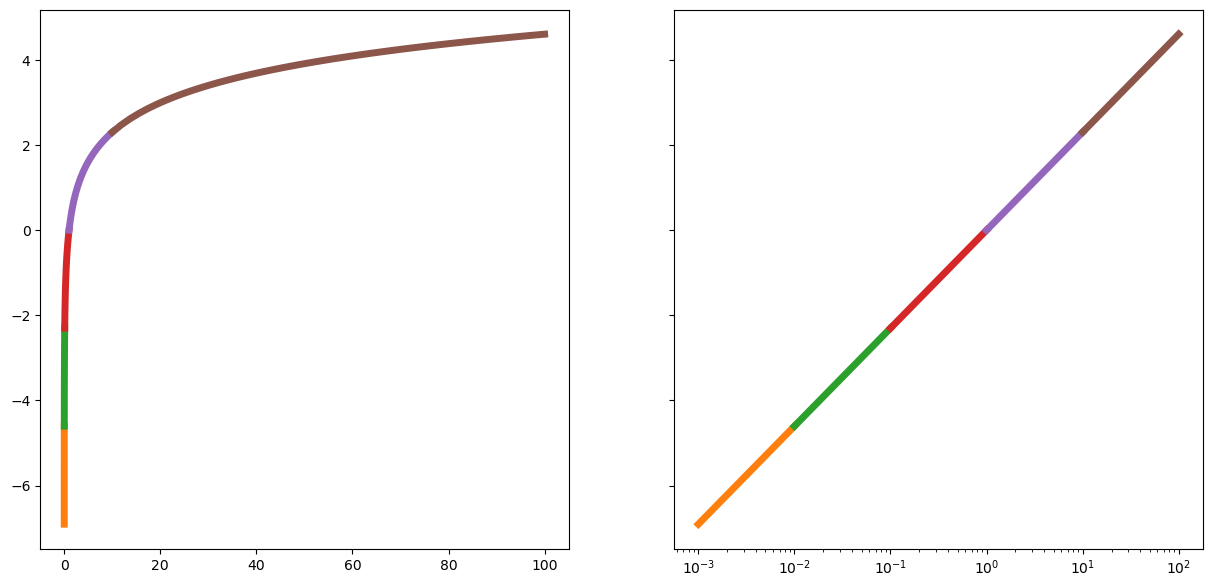

In [20]:
x = np.linspace(1e-3,1e2,1000)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,7),sharey=True)
ax1.plot(x,np.log(x))
ax2.set_xscale('log')
ax2.plot(x,np.log(x));

xs=np.linspace(1e-3,1e-2);ax2.plot(xs,np.log(xs),linewidth=5);ax1.plot(xs,np.log(xs),linewidth=5);
xs=np.linspace(1e-2,1e-1);ax2.plot(xs,np.log(xs),linewidth=5);ax1.plot(xs,np.log(xs),linewidth=5);
xs=np.linspace(1e-1,1);ax2.plot(xs,np.log(xs),linewidth=5);ax1.plot(xs,np.log(xs),linewidth=5);
xs=np.linspace(1,10);ax2.plot(xs,np.log(xs),linewidth=5);ax1.plot(xs,np.log(xs),linewidth=5);
xs=np.linspace(10,1e2);ax2.plot(xs,np.log(xs),linewidth=5);ax1.plot(xs,np.log(xs),linewidth=5);

# Bayes Rule

Now we've come to a very simple to prove, but very powerful theorem in probability, Bayes rule.

Lets start with the following observations:

$$
\begin{align}
P(A,B) &= P(A)P(B|A) \\
       &= P(B)P(A|B)
\end{align}
$$

So:

$$
P(A)P(B|A) = P(B)P(A|B)
$$

Solving for one of them:

$$
P(B|A) = \frac{P(B)P(A|B)}{P(A)}
$$

And thats it! This is Bayes rule! 

This is the simple probability rule presentation, but its usually stated like this:

Let $X$ be a random variable representing a latent (hidden) property you would **like to learn something about by gathering a dataset $Y$.**

Well, then we specify a **prior distribution** over our latent variable $X$: $P(X)$. This represent any information we have (or think we have) about $X$ **before** seeing any data. 

As an example, lets imagine we specify a Gaussian density: $\mathcal{N}(3,2)$:

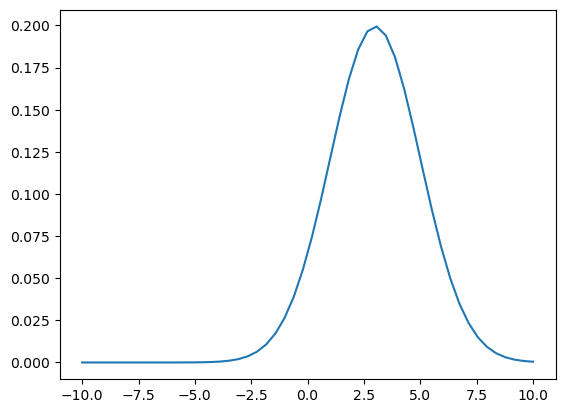

In [21]:
x = np.linspace(-10,10)
prior = lambda points: norm.pdf(points,loc=3,scale=2)
plt.plot(x,prior(x));

Note: this does **not** specify a probability of zero anywhere!

---



We also specify a **likelihood**: $P(Y|X)$ which is a **conditional probability** telling us how likely our data is **under different values of $X$**. 

**Note**: This likelihood is **a (conditional) distribution over $y$s!**. That is to say, once we specify a specific $X=x$ value to condition on, we have a distribution over all of our $Y$! 

Think about this point - its a very common point of confusion for students when they are first starting out. 

Lets give one:

In [22]:
y = np.linspace(48,84)
likelihood = lambda points,xval: norm.pdf(points,loc=xval,scale=10)

Now, lets plot this conditional probability for a specific x value: 

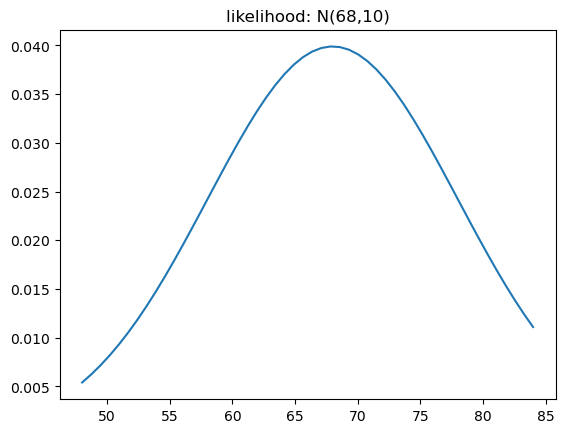

In [23]:
x_cond = 68
plt.plot(y,likelihood(y,x_cond));
plt.title(f"likelihood: N({x_cond},10)");

How does this behave for different values of x? Lets plot it! 

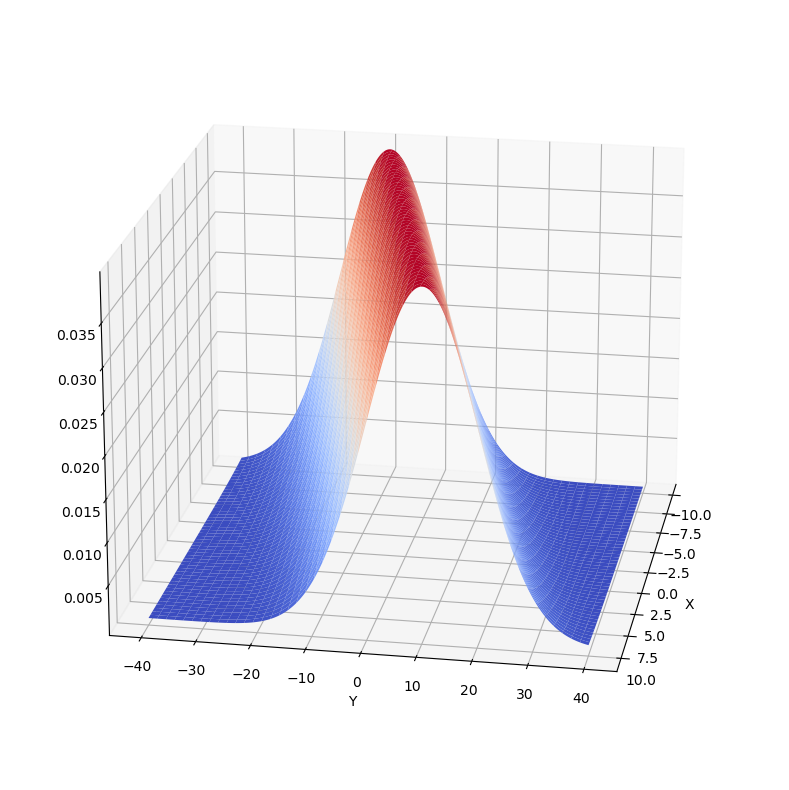

In [24]:
x_range = np.linspace(-10,10,1000)
y_range = np.linspace(-40,40,1000)
X,Y = np.meshgrid(x_range,y_range)
vals = likelihood(Y,X)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X,Y,vals,cmap='coolwarm');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.view_init(elev=20,azim=10)

In [97]:
if reanimate_gifs:
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X,Y,vals,cmap='coolwarm');
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    def update_graph(angle):
        ax.view_init(elev=30,azim=angle*2)

    anim = matplotlib.animation.FuncAnimation(fig, update_graph,
                                             frames=range(100),
                                             interval=50, blit=False)

    # HTML(anim.to_html5_video())
    anim.save('rotating_likelihood.mp4')
    
Video('rotating_likelihood.mp4', width=800)

---



We then multiply these two distributions to get the **numerator** in Bayes rule. This is **not** a true distribution (it does not integrate to 1). It needs to be **normalized**, by the **model evidence** $P(Y)$:


$$
\frac{P(X)P(Y|X)}{P(Y)}
$$

The model evidence is also almost always **calculated** using the law of **total probability**:

$$
P(Y) = \sum_i P(Y|X_i)P(X_i)
$$

So you will often find Bayes rule written as:

$$
P(X|Y) = \frac{P(X)P(Y|X)}{\sum_i P(X_i)P(Y|X_i)}
$$

The conditional distribution Bayes rule gives us is called **the posterior distribution**. 

So, one way to describe what Bayes rule is doing, is allowing us to **update our prior beliefs** represented by the **prior distribution** $P(X)$, by gathering **evidence/data**, represented by the **normalized-likelihood**: $\frac{P(Y|X)}{\sum_i P(X_i)P(Y|X_i)}$ to generate the posterior (conditional) distribution $P(X|Y)$.

$$
P(X) \overset{\text{Bayes Rule}}{\longrightarrow} P(X|Y)
$$

Another way to say this, is that it gives us a principled way to update our beliefs after gathering evidence. 

## Drug testing example

A common example problem for Bayes rule is the drug testing problem. 

Lets assume the following:


* probability of a general member of the public having a disease is $1/100000$
* probability of having a symptom given that you have the disease is: $1$.
* probability of a non-diseased person having a symptom is: $1/10000$. 
* 

$$
\begin{align}
P(\text{Disease} | \text{Symptoms}) &= \frac{P(\text{Disease})\;P(\text{Symptoms}|\text{Disease})}{P(\text{Symptoms})} \\
& = \frac{P(\text{Disease})\;P(\text{Symptoms}|\text{Disease})}{P(\text{Symptoms}|\text{Disease})P(\text{Disease}) + P(\text{Symptoms}|\text{NON-Disease})P(\text{NON-Disease})}
\end{align} 
$$

# Coin flip example

Often, any difficulty in sampling from the posterior distribution is side-stepped, by using **conjugate priors**. That is, priors that when multiplied by a particular likelihood, give you a known analytical form of the posterior. 

For example, a guassian prior and likelihood give you a gaussian prior. 

Then there is the usual coin-flip problem, where we are trying to guess the "fairness" (head/tails probability) of a coin $\theta$, based on flips $D$.

For this problem, a natural likelihood is the binomial/bernoulli distribution, and its conjugate prior is the beta distribution.

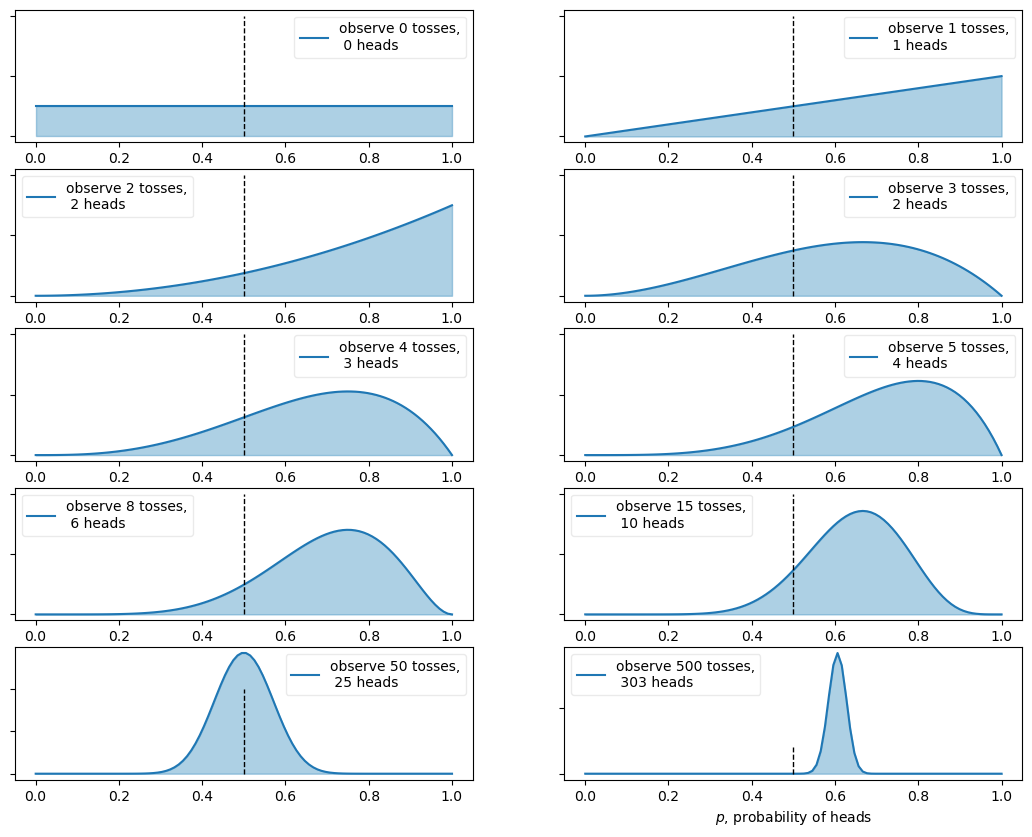

In [26]:
import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.6, size=n_trials[-1])
x = np.linspace(0, 1, 100)

plt.figure(figsize=(13,10))
for k, N in enumerate(n_trials):
    sx = plt.subplot(int(len(n_trials)/2), 2, k+1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)


In [98]:
coin_prob = 0.5
dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 100, 200, 300, 400, 500]
data = stats.bernoulli.rvs(coin_prob, size=n_trials[-1])

x = np.linspace(0, 1, 1000)

if reanimate_gifs:
    fig = plt.figure(figsize=(13,10))
    ax = plt.gca()
    dist_plot,=plt.plot([],[])
    ax.set_ylim([-0.1,24.1])
    ax.axes.get_yaxis().set_visible(False)

    def update_plot(i):
        N = n_trials[i]
        heads = data[:N].sum()
        y = dist.pdf(x, 1 + heads, 1 + N - heads)
        dist_plot.set_data(x, y)
        ax.fill_between(x, 0, y, alpha=0.4)
        ax.set_title(f'Trials:{N}, Heads:{heads}',fontsize=20)


    anim = matplotlib.animation.FuncAnimation(fig, update_plot,
                                             frames=range(len(n_trials)),
                                             interval=500, blit=False)

    # HTML(anim.to_html5_video())
    anim.save('coin_flips.mp4')
    
Video('coin_flips.mp4', width=800)

---

# Sampling

Above, we've seen how we can actually use the posterior distribution to represent our updated beliefs, after gathering data.


The problem we will be interested in, is when we **cannot easily sample from the posterior distribution**. This is almost always because we cannot calculate the **normalization constant**! 

So, we can only reason about the **shape** of our posterior:

$$
P(X|Y) \propto P(X) P(Y|X)
$$

This lets us make relative comparisons, and find point estimates, but not directly sample from the posterior! 

Critically, it also doesn't let us reason about the uncertainty in our estimates! For this, we need the actual samples!

## Variational Bayes

Often, you'll find Bayes rule written with a log:

$$
\log P(X|Y) = \log P(X) + \log P(Y|X) - \log P(Y)
$$

This form is often used in optimization problems, where we are tying to find a **variational approximation the posterior distribution**. 

In these problems, our data is **fixed**, and so we can rewrite Bayes rule to expose this **variational principle**:

$$
\begin{align}
\log P(Y) &= \log P(X) + \log P(Y|X) - \log P(X|Y) \\
          &= \log P(X) - [\log P(X|Y) - \log P(Y|X)] 
\end{align}
$$

Notice that the left hand side **does not change**. 

<div class="info">

<font size="6">🧐</font>**Pause-and-ponder**: Think about this. What does this suggest is a good thing to check for in an optimization problem? What is the left hand side? What about the right?
    
We can think about some pretty advanced methods using this basic observation!
    
</div>

We will not explore these topics further in this course, but we've gone a long way just by exposing you to this kind of thinking! 

## Inverse Transform Sampling

Lets start by looking at the CDF of a Gaussian RV:

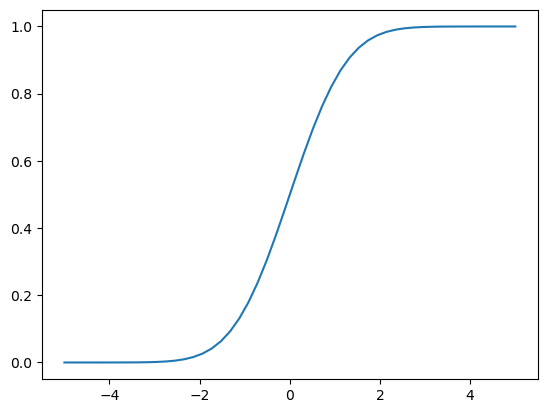

In [28]:
plt.plot(np.linspace(-5,5),norm.cdf(np.linspace(-5,5)));

Recall, this tells us:

$$
F_X(x) = P(X\leq x)
$$

<div class="info">

<font size="6">🧐</font>**Pause-and-ponder**: What happens if I plug in a Gaussian random variable into its own CDF? 
    
What question am I asking in doing so?
    
</div>

Lets cary the experiment out!

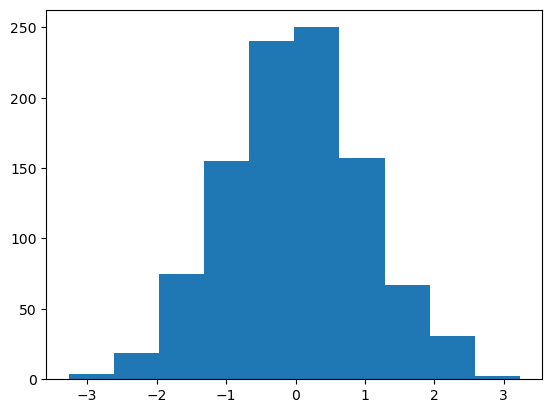

In [29]:
samples = np.random.standard_normal(1000)
plt.hist(samples);

Now lets plug them into the CDF and plot:

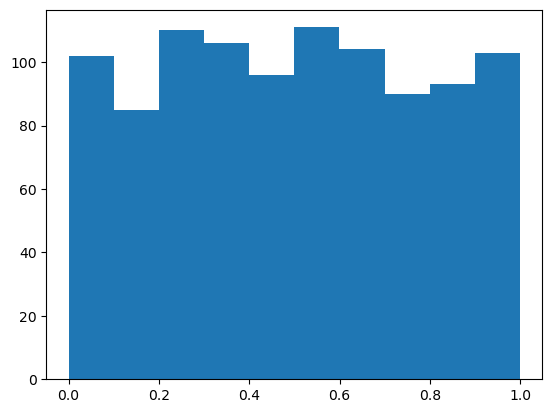

In [30]:
plt.hist(norm.cdf(samples));



<div class="info">

<font size="6">🧐</font>**Pause-and-ponder**: What do we see here? Does this make sense with what you said above? Think about this! 

</div>

Ah - A random variable plugged into its own CDF gives a uniform rv. 

Hm. So a CDF tell us the prob that $X$ is in a certain range. Well, it shouldn't surprise you that we can also define an **inverse cdf**, also called a **quantile function**, which is the "inverse" of this property. 

So in a CDF you plug in values, and get back a probability. Well, for an inverse CDF you plugin probabilities and get back values! 

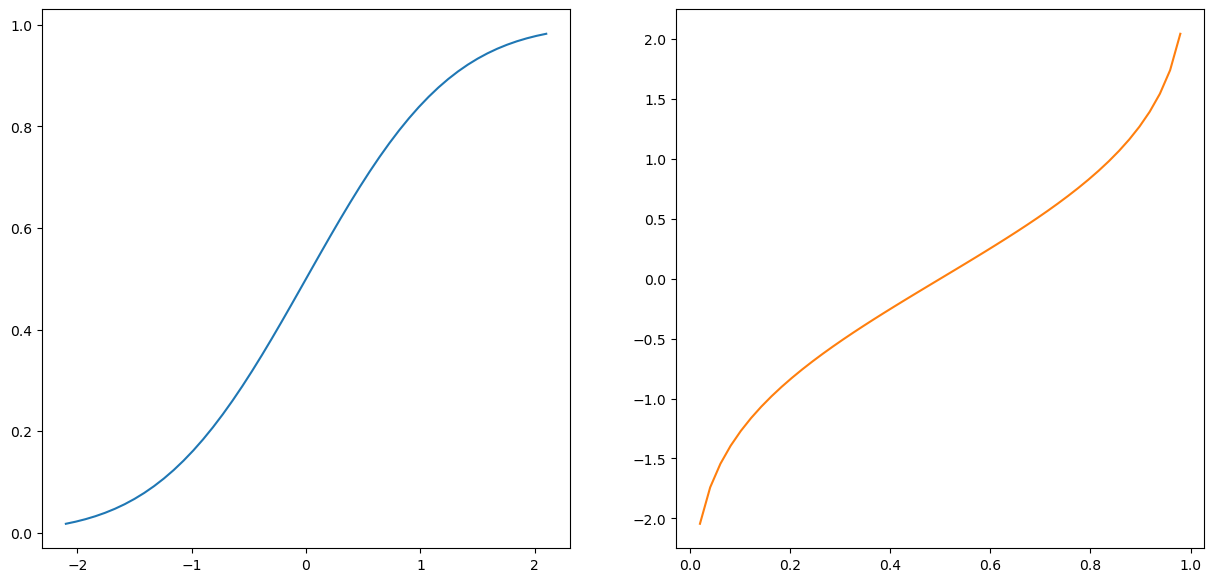

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))
x = np.linspace(-2.1,2.1)
ax1.plot(x,norm.cdf(x));

p = np.linspace(0,1)
ax2.plot(p,norm.ppf(p),c=sorange);

<div class="info">

<font size="6">🧐</font>**Pause-and-ponder**: What would happen if we plug in uniform values into an inverse CDF? What question is that asking? 

</div>


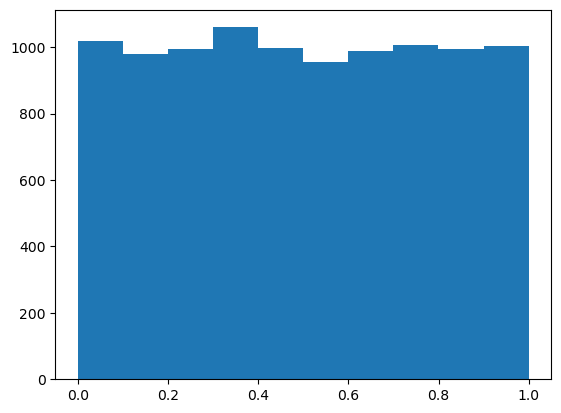

In [32]:
samples = np.random.rand(10000)
plt.hist(samples);

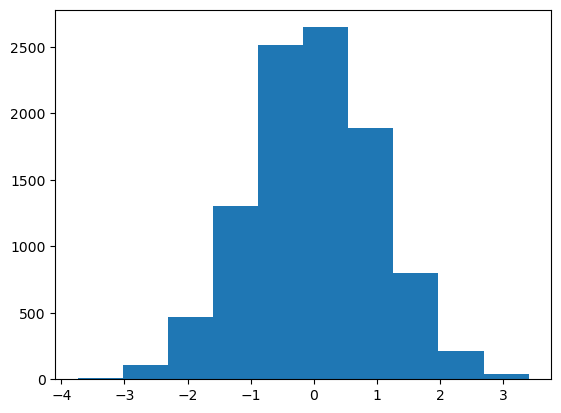

In [33]:
plt.hist(norm.ppf(samples));

Aha! So plugging in uniform values into an inverse CDF gives samples from the original CDF! 

We've discovered **inverse transform sampling**!

If we can:
* draw samples from a uniform distribution (easy)
* represent a distribution by its CDF (not always easy!)

We can easily draw samples from that distribution! 

## Rejection Sampling

Above, we saw one way to sample from a distribution. Lets look at another here.

Lets introduce it by way of a fun problem: try and build a **probabilistic** way to **estimate the value of $\pi$!**


<div class="info">

<font size="7">🗣</font>**Discuss**: Can anyone think of a way to do this? Lets 
    
</div>


Lets do one way: start by taking samples in the unit square:

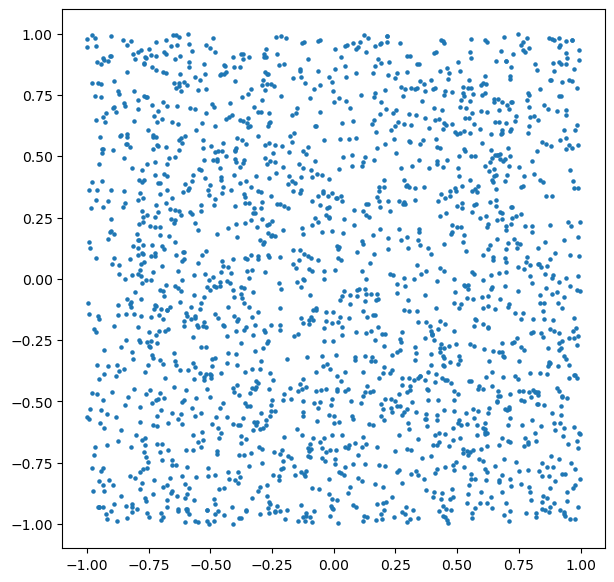

In [34]:
samples = np.random.rand(2000,2)*2-1

plt.figure(figsize=(7,7))
plt.scatter(samples[:,0],samples[:,1],s=5);

<div class="info">

<font size="6">🧐</font>**Pause-and-ponder**: How can we build an estimator for the value of $\pi$ from this?
    
</div>

Try it! Lets plot the unit-circle:

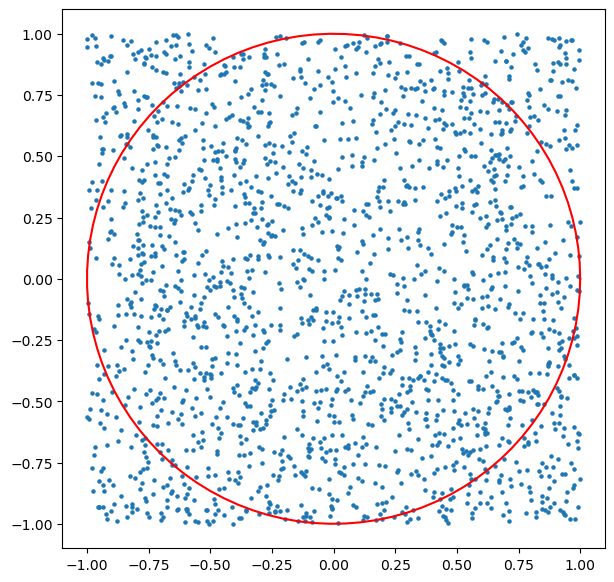

In [35]:
plt.figure(figsize=(7,7))
plt.scatter(samples[:,0],samples[:,1],s=5);
theta = np.linspace(0, 2*np.pi, 100);
r = np.sqrt(1.0);x1 = r*np.cos(theta);x2 = r*np.sin(theta)
plt.plot(x1,x2,'r');

Ah. So lets take the ratio of samples that fall in the unit circle, as an estimator **for its area**, and the total number of samples as estimator **for the the area of the square**. 

With this, we can calculate:

$$
\frac{\text{area of circle}}{\text{area of square}} = \frac{\pi r^2}{(2r)^2}  = \frac{\pi}{4}
$$

So the ratio of our areas is an estimator for $\pi/4$! 

Lets see how many samples fall within the unit circle:

In [36]:
inCirc = samples[:,0]**2 + samples[:,1]**2 <= 1

Lets plot them:

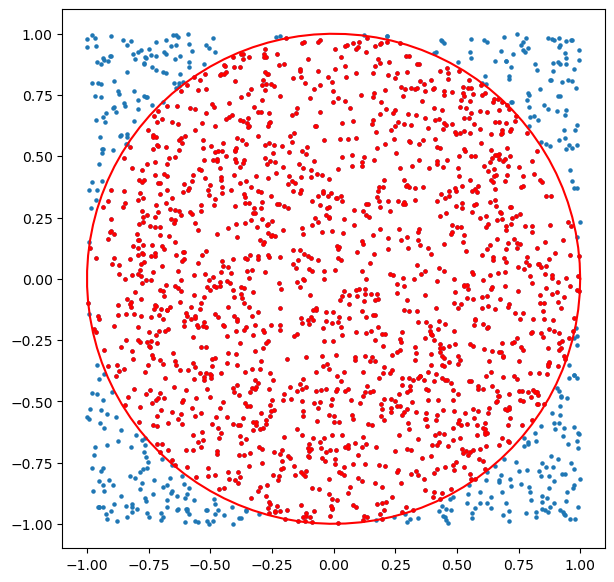

In [37]:
plt.figure(figsize=(7,7))
plt.scatter(samples[:,0],samples[:,1],s=5);
plt.plot(x1,x2,'r');
plt.scatter(samples[inCirc][:,0],samples[inCirc][:,1],s=5,c='r');

Ok! So we can count the proportion of red circles to total circles, giving us an estimate of the area of the circle relative to the square:

In [38]:
relArea = len(samples[inCirc])/len(samples)
relArea

0.783

Lets  multiply by 4 to see how we did! 

In [39]:
pi_est = relArea*4
pi_est

3.132

Hm. Not bad! Lets write a function and see how we do with more samples:

In [40]:
def estimate_pi(samples_list):
    vals = []
    for sample_num in samples_list:
        samples = np.random.rand(int(sample_num),2)*2-1
        inCirc = samples[:,0]**2 + samples[:,1]**2 <= 1
        vals.append(len(samples[inCirc])/len(samples))
    return vals

Lets plot it! 

In [41]:
samples_list = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
pi_estimates = estimate_pi(samples_list)

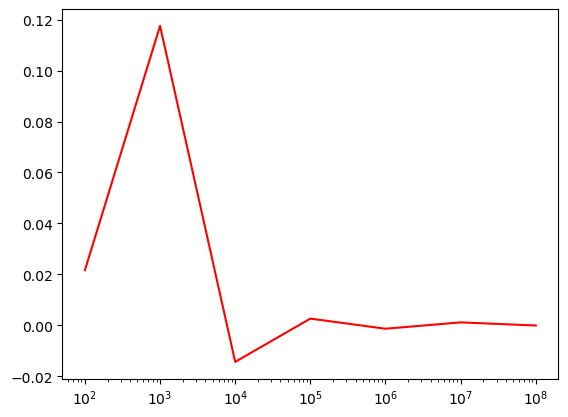

In [42]:
plt.plot(samples_list,[np.pi - curr*4 for curr in pi_estimates],c='r');
plt.gca().set_xscale('log')

We've looked at fun little rejection sampling problem. 

Broadly speaking, **rejection sampling** is interested in using a **proxy distribution** which is **easy to sample from**, to simulate samples from **another distribution** that its usually **hard** to sample from. 

It does this by **oversampling** from the easy one, and throwing away the ones that don't match an inclusion criteria (rejection them). Rejection samplers, therefore, have a concept of "efficiency", which tell you how many samples you needed to generate to have one included, or how many you ended up throwing away, etc. Or, how many samples do you need to achieve a certain accuracy, etc. 

They can be roughly thought of a kind of **Monte Carlo** technique, where **Monte Carlo Methods** can be described as **random sampling algorithms**. 

---



# Markov Chains
There is much more we can say about Monte Carlo methods more broadly, but our interest here is in using **Markov Chains** to build a sampler! Before we do this, lets take some time to explore them.

Before we get to coding, lets give the "formal" definition, based on the Markov property:

<div class="info">

<font size="6">📖</font>**Definition**: A random **processes** $X$ has the **markov property** if for all $n$ the following holds:
    
$$
P(X_{n+1} | X_1, X_2, \ldots, X_{n}) = P(X_{n+1}|X_{n})
$$

Another way to say this is
    
<center>Given the <strong>present</strong>, the <strong>past</strong> and the <strong>future</strong> are <strong>independent!</strong></center>
    
Even simpler: 
    
All you need to know about a markov chain to predict its next state, is its current state. You dont need everything else!
    
</div>

This property seems strange at first, but it makes intuitive sense if you think about it. 

---

Lets imagine the weather as having **three states**: Cold, Sunny, Rainy. (Lets forget about the fact that the real weather can occupy all three of these "states"). That is, any given day is **either** of these three. 

Lets first model what the weather would look like if we could randomly pick between these:

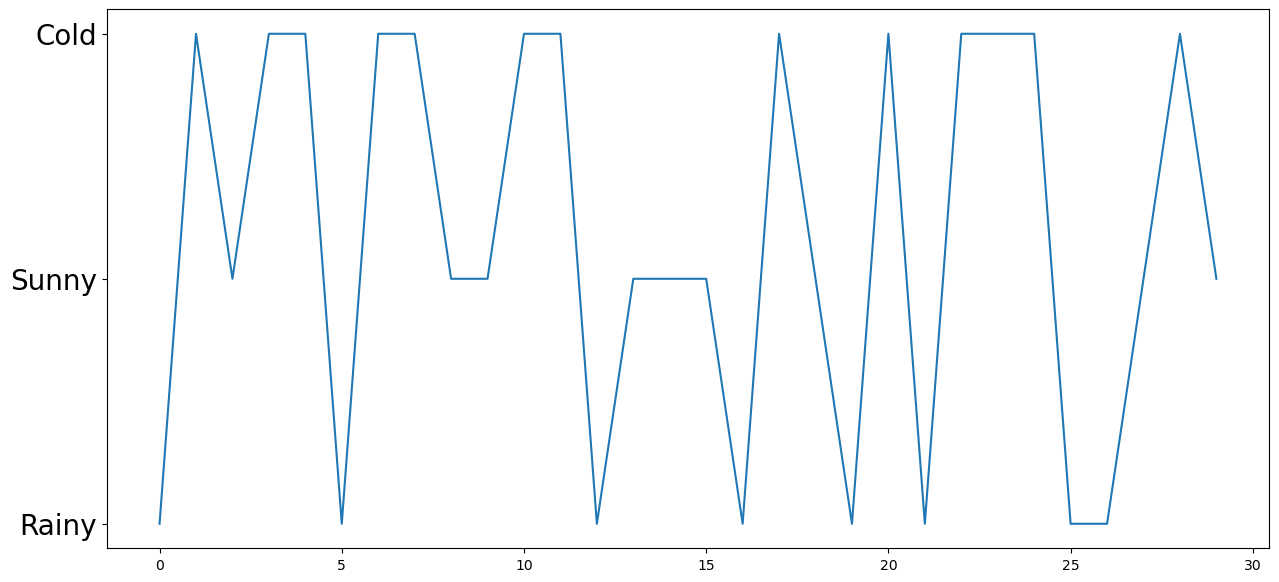

In [43]:
random_weather = np.random.randint(1,4,30)

plt.figure(figsize=(15,7))
plt.plot(random_weather);
plt.yticks(ticks=[1,2,3],labels=['Rainy','Sunny','Cold'],fontsize=20);

Yet another way we can visualize this, is by looking at the state path itself:

In [44]:
' '.join(np.random.choice(['R','C','S'],100).tolist())

'S C S R S C C C C R S R S C C R C R R R S R C R S C S R S R S C R S R C R S C R R C S R C C R C C C S S R R R S R C C S C S C R C R C R R C R S C C R S R S S S C R S C S C C C S R C R R R R R S R S S'

Hm. Lets see how often each state came up:

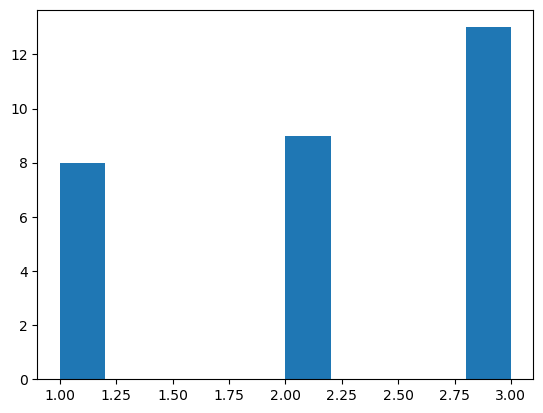

In [45]:
plt.hist(random_weather);

Pretty "uniform" I guess! 

But this seems unsatisfying. We can imagine the *real* weather (not really) has some "stickyness" to it! That is, if it was rainy today, it *should* be more likely that it its also rainy tomorrow. 

Lets visualize what this stickyness looks like, by **simulating** a markov chain!

The first thing we need, is a **transition matrix**. Each row of this matrix tells us the **conditional probability** of being in one state, and moving to any other state.

So, this matrix is:
* a square matrix, where its size is `num_states x num_states`
* **each row must sum to 1**.


One way to describe this matrix is:

$$
\begin{bmatrix}
P\left(\text{tommorow's weather}|\text{Rainy}\right) \\
P\left(\text{tommorow's weather}|\text{Sunny}\right) \\
P\left(\text{tommorow's weather}|\text{Cold}\right) \\
\end{bmatrix}
$$

A bit better:

$$
\begin{bmatrix}
P(rainy|rainy) & P(sunny|rainy) & P(cold|rainy) \\
P(rainy|sunny) & P(sunny|sunny) & P(cold|sunny) \\
P(rainy|cold) & P(sunny|cold) & P(cold|cold) \\
\end{bmatrix}
$$

Aha! So the diagonals of this matrix give us the probability of remaining in a state! The off-diagonals give us the probability of transitioning away from the current state.

Lets creaste one by hand to start off:

In [46]:
eps = 0.4
p = np.array([[1-eps,eps/2,eps/2],     # If rainy, moving to rainy, sunny, cold
              [eps/2,   1-eps,eps/2],     # If sunny, moving to rainy, sunny, cold
              [eps/2,eps/2,1-eps]])    # if cold,  moving to rainy, sunny, cold

Ok! Now our task is to **simulate** this chain, according to this transition matrix! 

So, starting at some initial state, we want to pick a state according to the "correct" distribution.

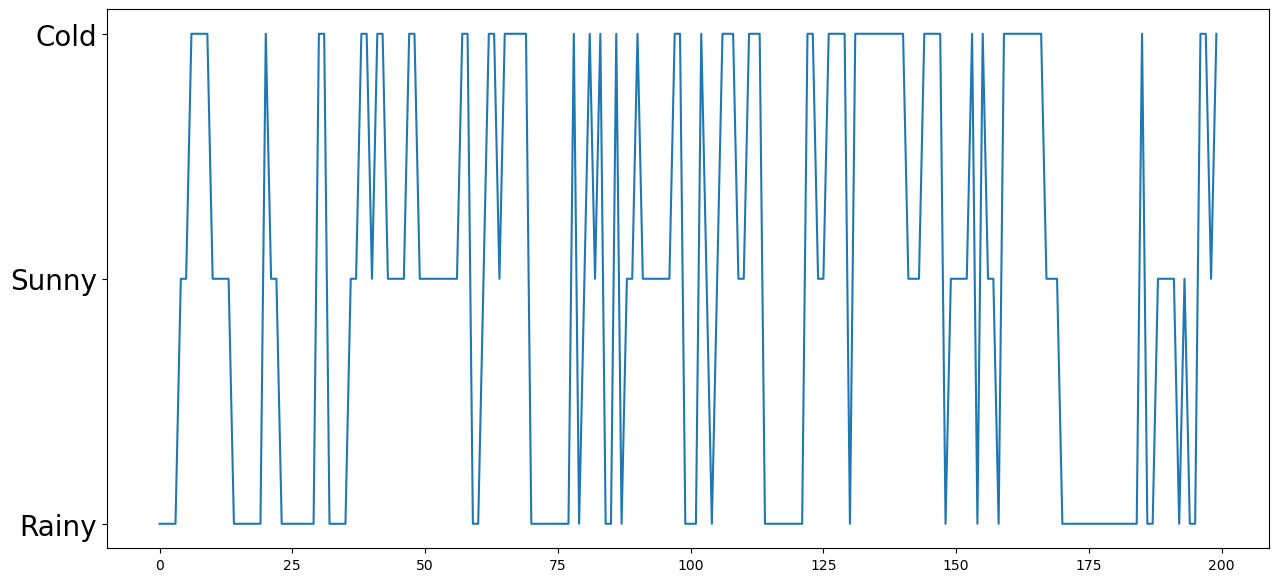

In [47]:
s_0 = 0 # rainy
steps = 200
states = []
states.append(s_0)

# simulate the walk
for t in range(1, steps):
    s_curr = states[t-1]
    p_curr = p[s_curr,:]
    s_next = np.random.choice([0,1,2],p=p_curr)
    states.append(s_next)
    
plt.figure(figsize=(15,7))
plt.plot(states);
plt.yticks(ticks=[0,1,2],labels=['Rainy','Sunny','Cold'],fontsize=20);

Hm. This is indeed qualitatively different! 

<div class="info">

<font size="7">🧐</font>**Pause-and-ponder**: Play around with the above, and jot down some observations below!
    
</div>

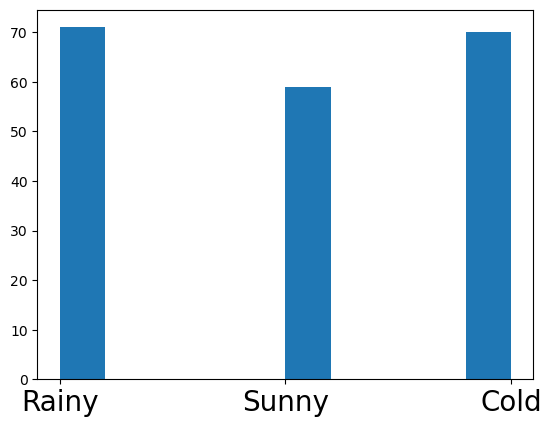

In [48]:
plt.hist(states);
plt.xticks(ticks=[0,1,2],labels=['Rainy','Sunny','Cold'],fontsize=20);

Ok, lets make this into a function, so we can keep going!

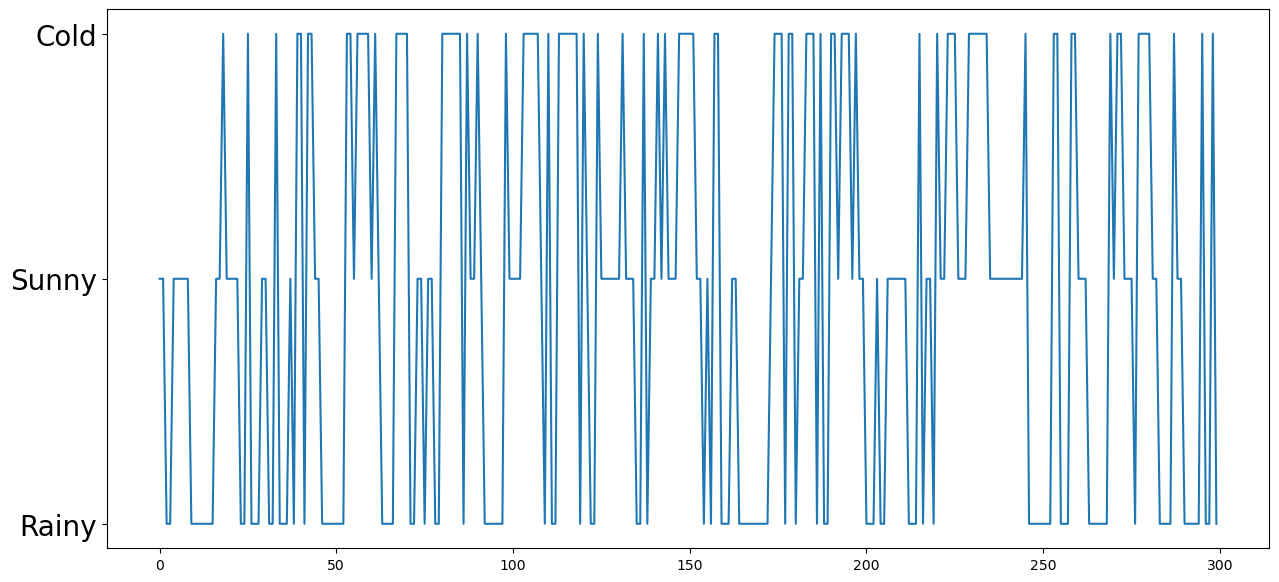

In [49]:
def simulate_chain(s_0, p, steps):
    states = []
    states.append(s_0)

    # simulate the walk
    for t in range(1, steps):
        s_prev = states[t-1]
        p_curr = p[s_prev,:]
        s_t = np.random.choice([0,1,2],p=p_curr)
        states.append(s_t)
        
    return np.array(states)
    

states = simulate_chain(1,p,300)
plt.figure(figsize=(15,7))
plt.plot(states);
plt.yticks(ticks=[0,1,2],labels=['Rainy','Sunny','Cold'],fontsize=20);

Lets simulate multiple random walks! From random starting positions! 

In [50]:
eps = 1e-4
p = np.array([[1-eps,eps,0],     # If rainy, moving to rainy, sunny, cold
              [0,1-eps,eps],     # If sunny, moving to rainy, sunny, cold
              [eps,0,1-eps]])    # if cold,  moving to rainy, sunny, cold

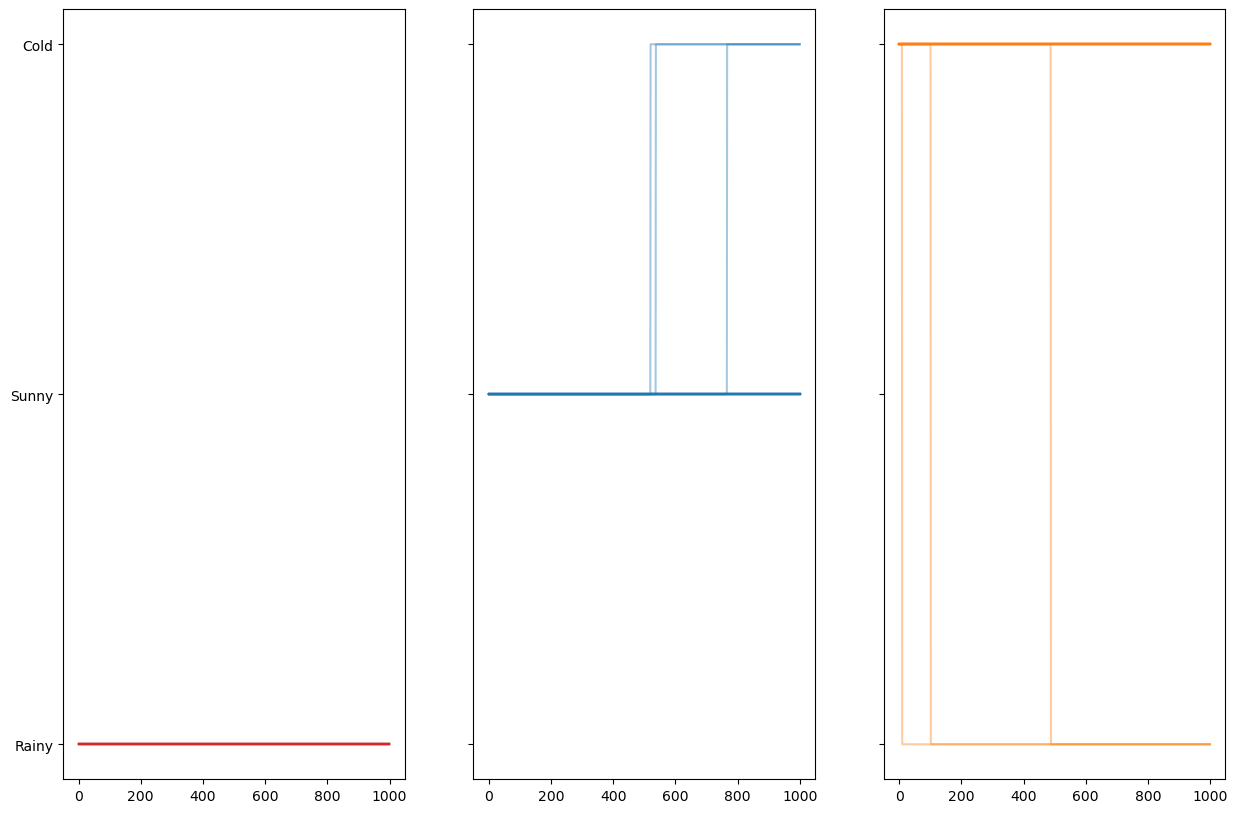

In [51]:
num_walks = 100
steps = 1000
walks_mat = np.zeros((num_walks,steps))

# go through each chain
for walk in range(num_walks):
    s_0 = np.random.choice([0,1,2])
    walks_mat[walk,:] = simulate_chain(s_0,p,steps)
    

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10),sharey=True)
plt.yticks(ticks=[0,1,2],labels=['Rainy','Sunny','Cold'],fontsize=20);

ax1.plot(walks_mat[walks_mat[:,0] == 0].T,c=sred,alpha=0.4);
ax2.plot(walks_mat[walks_mat[:,0] == 1].T,c=sblue,alpha=0.4);
ax3.plot(walks_mat[walks_mat[:,0] == 2].T,c=sorange,alpha=0.4);

Before we continue the analysis, lets look at another type of common example: modeling a change in population.

Here we're going to consider a Markov chain which represents the population of a group of people on an island. To simplify our analysis, were going to assume that there can only be a maximum of $100$ of people alive on this island at any one time.

At each point in time:
* 1 additional person can arrive on the ferry
* 1 person can leave on the ferry
* Or nothing: there is no change in our population

In [52]:
N = 100    # maximum population size
prob_change = [0.1,0.4,0.5]   # arrive, leave, no change

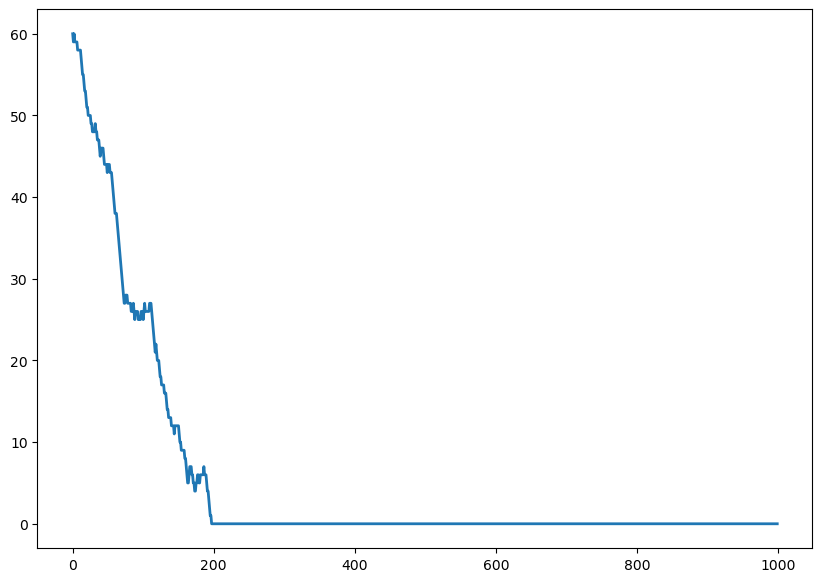

In [53]:
nsteps = 1000
x = np.zeros(nsteps)
x[0] = 60

for t in range(nsteps - 1):
    if 0 < x[t] < N - 1:
        pop_change = np.random.choice([1,-1,0],p=prob_change)
        x[t + 1] = x[t] + pop_change
        
    # The evolution stops if we reach $0$ or $N$.
    else:
        x[t + 1] = x[t]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(x, lw=2);

<div class="info">

<font size="7">🧐</font>**Pause-and-ponder**: Play around with the above, and jot down some observations below!
    
</div>

Lets make it into a function to play around! 

In [54]:
def run_island_chains(n_steps,n_chains,initial_pop,prob_change):
    x = np.zeros((n_steps,n_chains))

    for chain_idx in range(n_chains):
        
        x[0,chain_idx] = initial_pop
        
        # run the chain
        for t in range(n_steps - 1):
            if 0 < x[t,chain_idx] < N - 1:
                pop_change = np.random.choice([1,-1,0],p=prob_change)
                x[t + 1,chain_idx] = x[t,chain_idx] + pop_change

            # The evolution stops if we reach $0$ or $N$.
            else:
                x[t + 1,chain_idx] = x[t,chain_idx]
                
    return x

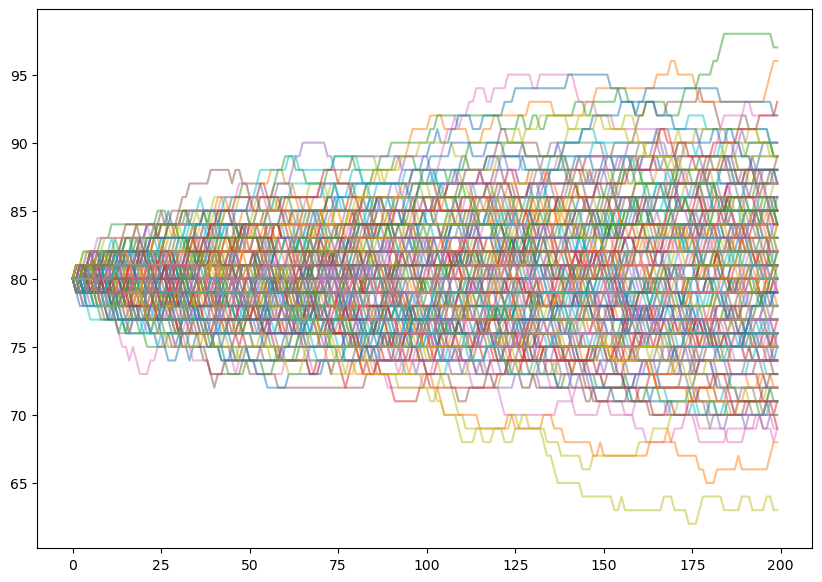

In [55]:
n_steps = 200
n_chains = 200
initial_pop = 80
prob_change = [0.1,0.1,0.8]   # arrive, leave, no change
chains = run_island_chains(n_steps,n_chains,initial_pop,prob_change)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(chains,alpha=0.5);

<div class="info">

<font size="7">🧐</font>**Pause-and-ponder**: Play around with the above, and jot down some observations below!
    
</div>

What does it mean for our chain to "stop moving" if it reaches 100 or 0? How can we visualize the evolution of a chain without running it? 

Well, we can describe a Markov Chain by a directed graph often called a **State Transition Diagram**. 

For the weather chain above, it would look like: 

---

Lets make it together! 

Add it here when we're done! 

---

<div class="info">

<font size="7">🧐</font>**Pause-and-ponder**: What about for the population example?
    
</div>

## Evolving Distributions

Previously, we've been simulating a chain and plotting trajectories to try and understand them.

But we can do better! 

We can do better by imagining not running a particular chain, but asking ourselves, how does a transition matrix **affect a distribution**? 

Or, given a **starting distribution**, what can I say about the **ending distribution**?

This idea may seem strange at first. Maybe even at second! But thats ok - let dig in and explore it some more. 

Lets go back to the weather example:

In [56]:
p_weather = np.array([[0.7,0.2,0.1],     # If rainy, moving to rainy, sunny, cold
                     [0.1, 0.8,0.1],     # If sunny, moving to rainy, sunny, cold
                     [0.1,0,0.9]])    # if cold,  moving to rainy, sunny, cold

Lets pick a simple starting distribution: We always start in the raining state. Well, then this would be:

In [57]:
initial_dist = np.array([0.5,0.4,0.1])

Before we try and understand the formula, lets first try to "run it through once" and understand the result:

<div class="info">

<font size="7">🧐</font>**Pause-and-ponder**:What are we looking at here? What do you notice? Discuss! 
    
</div>

Hm. Lets check our understanding by running it through twice! 

In [58]:
(initial_dist.dot(p_weather)).dot(p_weather)

array([0.34 , 0.416, 0.244])

Hm... what do we notice?

What if we keep going? Lets try to make this a bit nicer so we can see whats happening:

In [59]:
num_steps = 100
dists = [initial_dist]
step = initial_dist.dot(p_weather)
dists.append(step)
for _ in range(num_steps):
    step = step.dot(p_weather)
    dists.append(step)

In [99]:
if reanimate_gifs:
    fig, ax = plt.subplots(1,1,figsize=(10,7));
    markerline,stemline,baseline = ax.stem(dists[0],basefmt='--w',use_line_collection=True);
    plt.xticks([0,1,2],labels=['Rainy','Sunny','Cold'],fontsize=20);

    def update_graph(frame):
        ax.cla();
        markerline, stemlines, baseline = ax.stem(dists[frame],basefmt='--w',use_line_collection=True);
        ax.set_ylim((-0.01, 1.01));
        plt.xticks([0,1,2],labels=['Rainy','Sunny','Cold'],fontsize=20);
        ax.set_title(f'Step:{frame}');
        xs = np.array([0,1,2])
        ys = np.array(dists[frame])
        for x,y in zip(xs,ys):
            plt.annotate(f'{y:.2f}', xy=(x,y), xytext=(0,5), 
                         textcoords='offset points',ha='center',fontsize=20);

    anim = matplotlib.animation.FuncAnimation(fig, update_graph, 
                                              frames=range(len(dists)), interval=500);
    # HTML(anim.to_html5_video())
    anim.save('mc_evolve.mp4')
    
Video('mc_evolve.mp4', width=800)

<div class="info">

<font size="7">🧐</font>**Pause-and-ponder**:What are we looking at here? What do you notice? Discuss! 
    
</div>

We've discovered the stationary distribution of this chain! 

**Its the distribution of where we can expect to find the chain after enough time!**



Interestingly (very much so!) we can calculate this by **taking the matrix power of the transition matrix directly!**


In [61]:
np.linalg.matrix_power(p_weather,num_steps)

array([[0.25, 0.25, 0.5 ],
       [0.25, 0.25, 0.5 ],
       [0.25, 0.25, 0.5 ]])

Then, we just left-multiply this by our initial distribution: 

In [62]:
initial_dist.dot(np.linalg.matrix_power(p_weather,num_steps))

array([0.25, 0.25, 0.5 ])

---

Lets bring back the population example and make it more interesting. To make it explicit, lets create that "big" transition matrix I told you about previously:

In [63]:
eps = 2/3  # prob 
prob_change_island = np.array([1/3,1/3,1/3])   # leave, no change, arrive

In [64]:
p_island = np.zeros((101,101))
p_island[0,0] = 1     # if we are at zero, we stay at zero
p_island[-1,-1] = 1   # if we are 100, we stay at 100

In [65]:
# p_island = np.zeros((101,101))
for curr_pop in range(1,100):
    p_island[curr_pop,curr_pop-1:curr_pop+2] = prob_change_island

In [66]:
p_island

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.33333333, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333333, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.33333333,
        0.33333333],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [67]:
(np.sum(p_island,axis=1)==1).all()

True

Now lets simulate it! 

In [68]:
num_steps = 3000
initial_dist = np.zeros(101)
initial_dist[50] = 1
dists = [initial_dist]
step = initial_dist.dot(p_island)
dists.append(step)
for _ in range(num_steps):
    step = step.dot(p_island)
    dists.append(step)

In [100]:
if reanimate_gifs:
    fig, ax = plt.subplots(1,1,figsize=(10,7));
    ax.get_yaxis().set_visible(False)
    markerline,stemline,baseline = ax.stem(dists[0],basefmt='--w',use_line_collection=True);

    def update_graph(frame):
        ax.cla();
        markerline, stemlines, baseline = ax.stem(dists[frame],basefmt='--w',use_line_collection=True);
        ax.set_title(f'Step:{frame}');

    anim = matplotlib.animation.FuncAnimation(fig, update_graph, 
                                              frames=range(1,len(dists),100), interval=100);
    plt.close();
    # HTML(anim.to_html5_video())
    anim.save('mc_evolve_2.mp4')
    
Video('mc_evolve_2.mp4', width=800)

<div class="info">

<font size="7">🧐</font>**Pause-and-ponder**:What are we looking at here? What do you notice? Discuss! 
    
</div>

Lets use our matrix power formula to verify:

/var/folders/1j/c5scsycs1s5_nzj08g133rp40000gn/T/ipykernel_5554/544233340.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(initial_dist.dot(np.linalg.matrix_power(p_island,end_point)),use_line_collection=True);


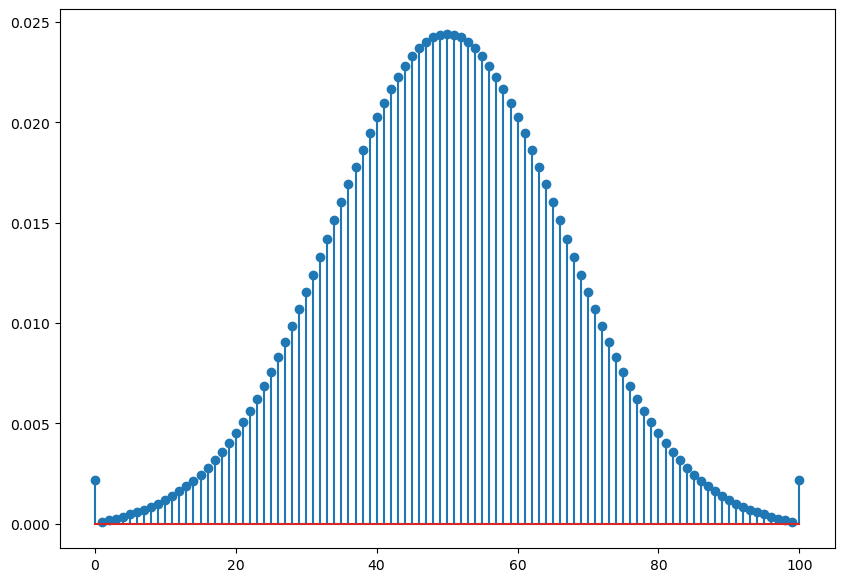

In [70]:
end_point = 400
plt.figure(figsize=(10,7))
plt.stem(initial_dist.dot(np.linalg.matrix_power(p_island,end_point)),use_line_collection=True);

Wow! What have we discovered?

<div class="info">

<font size="7">🧐</font>**Pause-and-ponder**:What are we looking at here? What do you notice? Discuss! 
    
</div>

# Monte Carlo Integration

Above, we described "Monte Carlo methods" as **random sampling schemes**. This is a coarse definition, but it works for our purposes. 

We motivated this whole thing by saying we wanted to use these kind of schemes to **estimate an integral** that we couldn't otherwise calculate. 

But - a **huge** open question remains:

<div class="info">

<font size="7">🤷🏽‍♂️</font> What does this have to with integration?! <font size="6">📈</font>    
    
</div>

Lets remind ourselves of what integration means:

One way to describe this integral:
$$
\int_a^b f(x)dx
$$

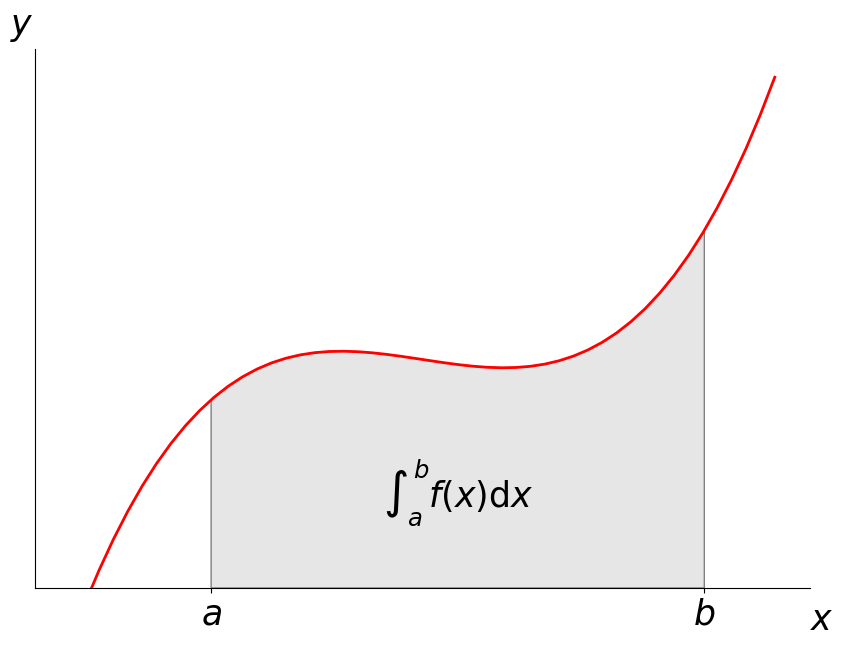

In [71]:
from matplotlib.patches import Polygon

def func(x):
    return (x - 3) * (x - 5) * (x - 7) + 85

a, b = 2, 9  # integral limits
x = np.linspace(0, 10)
y = func(x)

# create plot
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(x, y, 'r', linewidth=2)
ax.set_ylim(bottom=0)

# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
verts = [(a, 0), *zip(ix, iy), (b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

ax.text(0.5 * (a + b), 30, r"$\int_a^b f(x)\mathrm{d}x$",
        horizontalalignment='center', fontsize=25)

fig.text(0.9, 0.05, '$x$',fontsize=25)
fig.text(0.1, 0.9, '$y$',fontsize=25)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.set_xticks((a, b));
ax.set_xticklabels(('$a$', '$b$'),fontsize=25);
ax.set_yticks([]);

If we want to **estimate** this region, one thing we can do is to take the fraction of random points that fall **below** the function $f$, multiplied by the **area** (often referred to as volume or its higher dimension analog: *measure* in more than 1/2 dimensions) of the region.

Yet another, is to **uniformly sample the function at random points and multiply that by the volume of the region**. 

<div class="info">
    
<font size="7">🧑🏽‍🏫</font>**Recall:** How are these related to your traditional definition of an integral?
    
</div>

---

Lets recall the definition of the expected value of a function $g$ of a random variable $X$:

$$
E[g(X)] = \int_\mathbb{R} g(x) p(x) dx 
$$

where $x$ are specific realizations of the random variable $X$, and $p(\cdot)$ is the *density*.

**Note** were skipping all the technical details of this being a [**Lebesgue integral**](https://en.wikipedia.org/wiki/Lebesgue_integration)

If we choose $g(x) = f(x)/p(x)$, then we have:

$$
\begin{align}
E[g(x)] &= \int \frac{f(x)}{p(x)} p(x) dx \\
        &= \int f(x)dx
\end{align}
$$

which is what we wanted! 

If $p$ is **uniform** on $[a,b]$, then 

$$
g(x) = \frac{f(x)}{\frac{1}{b-a}} = (b-a)f(x)
$$

The interesting part for us, is that we will **estimate** this integral, using the obvious estimator! The **empirical mean**! 

$$
E_n = \frac{1}{n} \sum g(x_i)
$$

where all $x_i$ are drawn from $p$. 


Well, the [**Law of Large Numbers**](https://en.wikipedia.org/wiki/Law_of_large_numbers) guarantees that this approaches the true expected value! 

<div class="info">

<font size="7">🧑🏽‍🏫</font>**Recall:** How is this different than the Central Limit  Theorem?
    
</div>

---

Ok! So we've established were going to estimate an integral, using random samples! Lets define our estimator of choice!

Say we want to estimate:

$$
F = \int_a^b f(x) dx
$$

We will approximate this by **averaging samples of the function $f$ at uniform random points in the interval.**


<div class="info">

<font size="6">📜</font>**Definition**: Given a set of $N$ uniform random variables: $X_i \in [a,b)$, the **Simple Monte Carlo Estimator** $F^N$ is given by:

$$
F^N = (b-a) \frac{1}{N} \sum^N f(X_i)
$$
    
</div>

Intuitively, this Monte Carlo estimator computes the mean value of the function $f(x)$ over the interval $a$ to $b$, and then multiplies this mean by the length of the interval $(b − a)$. 

By moving $(b − a)$ into the summation, the estimator can be thought of as **choosing a height** at a random evaluation of the function and **averaging a set of rectangular areas** computed by multiplying this height by the interval length $(b − a)$.

![](mc-int.png)


Note: This basic Monte Carlo estimator can easily be extended to **multiple dimensions**, and, in contrast to other deterministic estimation techniques, the convergence rate for Monte Carlo is **independent of the number of dimensions in the integral!**. 

This makes Monte Carlo integration the only practical technique for many high dimensional integration problems.

---

Lets look at a simple example and find the integral of $e$!

$$
\int_0^1 e^x dx
$$

Lets first check the correct analytical solution:

In [72]:
from sympy import symbols, integrate, exp
x = symbols('x')
expr = integrate(exp(x), (x,0,1))
true_val = float(expr.evalf())
true_val

1.7182818284590453


Ok! Thats what we have to hit. Lets plot the function, as well as our random samples:

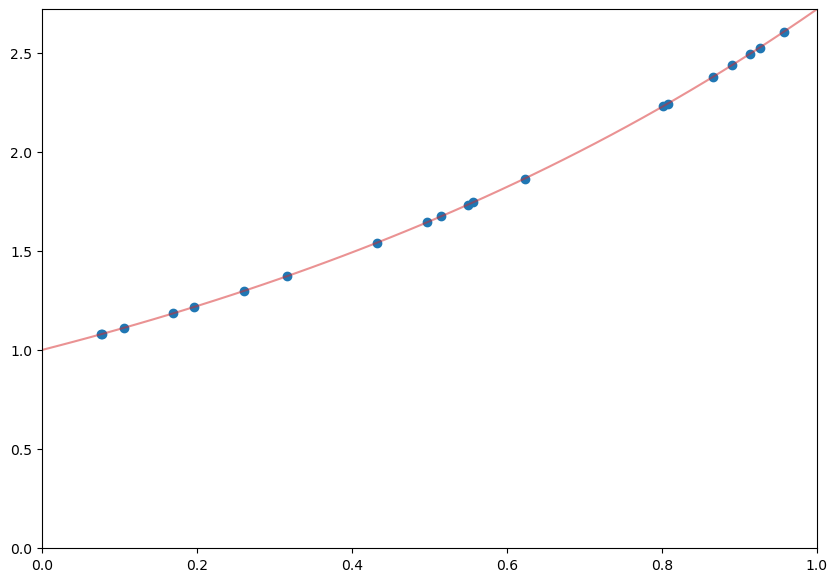

In [73]:
x = np.linspace(0, 1)
pts = np.random.uniform(0,1,20)

plt.figure(figsize=(10,7))
plt.plot(x, np.exp(x),color=sred,alpha=0.5);
plt.scatter(pts, np.exp(pts))
plt.xlim([0,1])
plt.ylim([0, np.e]);

In [74]:
estimates = []
points_list = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]

for num_points in points_list:
    x = np.random.uniform(0, 1, int(num_points))
    sol = np.mean(np.exp(x))
    
    estimates.append(sol)
    
estimates = np.array(estimates)

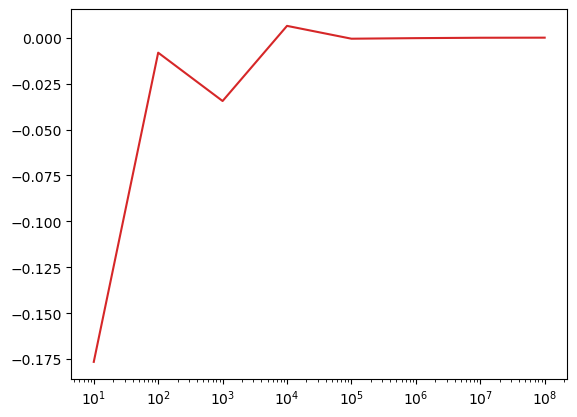

In [75]:
plt.plot(points_list,true_val-estimates,color=sred);
plt.gca().set_xscale('log')

Ok. Above, we can see "how close we are", because we know the true value. However, in general **we don't**. 

Indeed, **thats why we're trying to estimate this in the first place**! So measuring our error is not a good criteria in Monte Carlo integration. 

Instead, we want some idea of when our Monte Carlo estimate has "converged". To get a handle on this, we need to estimate the **variance**. 

Lets pick another simple example function to integrate:

$$
f(x) = x\cos 7x + \sin 13x, \quad 0\leq x \leq 1
$$

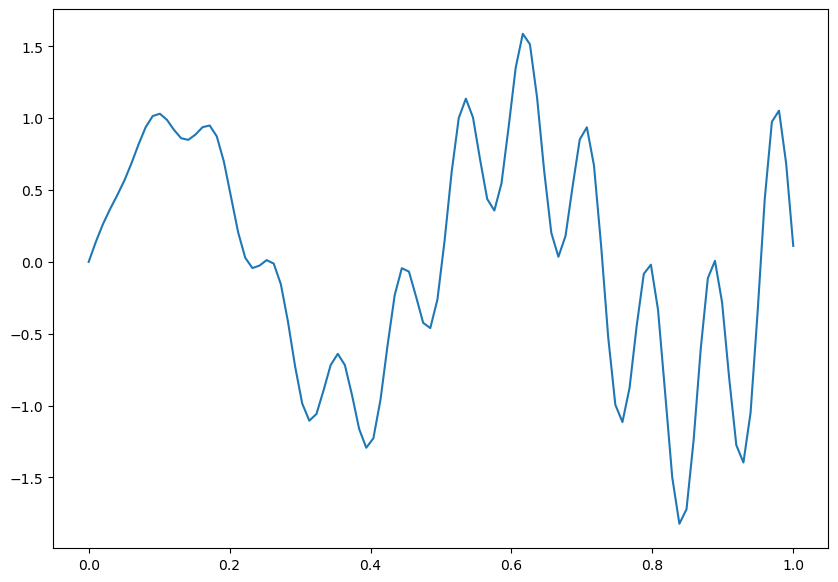

In [76]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)

x = np.linspace(0, 1, 100)
plt.figure(figsize=(10,7))
plt.plot(x, f(x));

As above, lets calculate the analytical solution:

In [77]:
from sympy import sin, cos, symbols, integrate

x = symbols('x')
true_val = float(integrate(x * cos(71*x) + sin(13*x), (x, 0,1)).evalf(6))
true_val

0.020254939794540405

Ok! Lets estimate this by picking 100 points:

In [78]:
pts = np.random.random(100)
mc_estimate = 1/100 * np.sum(f(pts))
mc_estimate

0.06195468921764444

As we did above, lets run this experiment **multiple times**, by varying the number of points we use to evaluate the function:

In [79]:
num_experiments = 1000
num_points = 100

estimates = np.zeros((num_points,num_experiments))

for exp_num in range(num_experiments):
    for point_nums in range(num_points):
        pts = np.random.random(point_nums+1)
        estimate = 1/len(pts) * np.sum(f(pts))
        estimates[point_nums,exp_num] = estimate
        
upper, lower = np.percentile(estimates, [2.5, 97.5], axis=1)

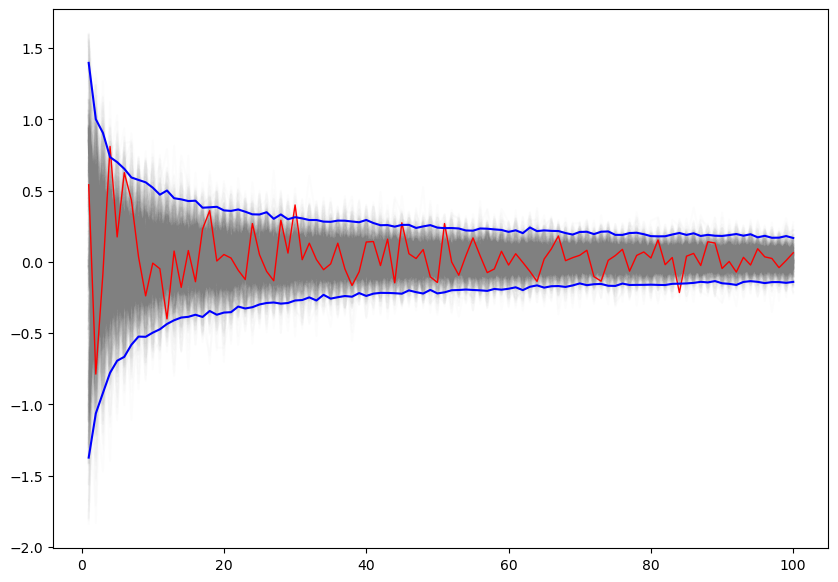

In [80]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(1, num_points+1), estimates, c='grey', alpha=0.02);
plt.plot(np.arange(1, num_points+1), estimates[:, 0], c='red', linewidth=1);
plt.plot(np.arange(1, num_points+1), upper, 'b', np.arange(1, num_points+1), lower, 'b');

And for completion, this how we could have run this experiment using **broadcasting**:

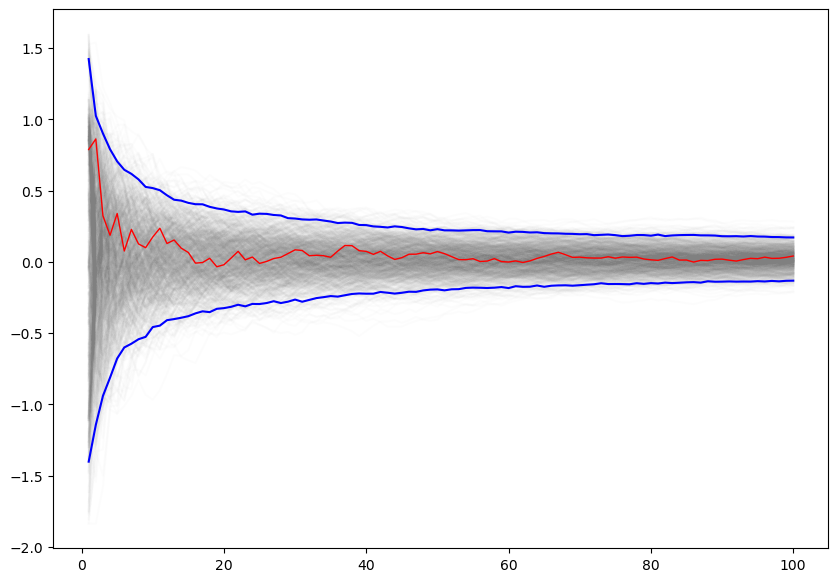

In [81]:
num_experiments = 1000
num_points = 100

vals = f(np.random.random((num_points, num_experiments)))
estimates = 1/np.arange(1, num_points+1)[:, None] * np.cumsum(vals, axis=0)
upper, lower = np.percentile(estimates, [2.5, 97.5], axis=1)


plt.figure(figsize=(10,7))
plt.plot(np.arange(1, num_points+1), estimates, c='grey', alpha=0.02)
plt.plot(np.arange(1, num_points+1), estimates[:, 0], c='red', linewidth=1);
plt.plot(np.arange(1, num_points+1), upper, 'b', np.arange(1, num_points+1), lower, 'b');

<div class="info">

<font size="7">🤷🏽‍♂️</font>**Pause-and-ponder**: What is this converging too?  
    
</div>

# Markov Chain Monte Carlo

Finally! We've arrived! Getting here has not been easy! We've covered:

* Markov Chains
  * specifying them
  * simulating them
  * stationary distribution emerging after running for a long time
* Monte Carlo methods
  * random sampling schemes to approximate Pi
  * MC Integration
  
We **motivated** MCMC, by saying we wanted to use it to sample from a Bayesian posterior. But, this was just a motivation. MCMC is used to sample from a **target distribution** that is difficult to sample from. It is not limited the Bayesian setting.

Suppose we want to sample from a distribution $\pi$, which we will call the **target distribution**. Below, we will introduce the **Metropolis Algorithm**, which **simulates a Markov Chain** whose **stationary distribution** is $\pi$!. 

This means that, **in the long run**, the samples from the Markov chain look like the samples from $\pi$. As we will see, the algorithm is incredibly simple and flexible. Its main limitation is that, for difficult problems, "in the long run" may mean **after a very long time**. 

---

## Metropolis Algorithm

Lets first state the algorithm, and then try and analyze it.

We begin by picking, or specifying, a **proposal distribution**, or **transition kernel**: $Q$. You can think of it as specifying a **probabilistic** way of moving, randomly, to a new position in space ($y$ say), **given** a current position ($x$ say). That is, $Q$ is a **distribution** on $y$ **given** $x$, and we will write it: $Q(y|x)$. 

Note: when were working continuously, then $Q$ will be a **density** on $y$.

As an example, lets choose the **random walk kernel/proposal**, which is a fancy way to say:

<center>The Gaussian™ <font size="6">😎</font></center>
    

Under this proposal, if we start at a position $x$, then our next position will be a standard Normal away:

$$
y = x + \mathcal{N}(0,1)
$$

This makes our *conditional* distribution $Q(y|x)$, or the **transition kernel** be centered on our current location:

$$
Q(y|x) = \mathcal{N}(x,1)
$$

**Note:** Often, we don't want the variance to be $1$. This could cause us to take too large steps! 

Now we can actually **define the algorithm**:

<div class="info">

<font size="7">👾</font>**Metropolis Algorithm Definition**:

Initialize $X_1$ to some value: $X_1=x_1$. For $t= 1,2,\ldots$:
  1. sample from the **proposal distribution**: $ y \sim Q(y|x_t)$. We are **proposing** this value to be $x_{t+1}$.  
  2. compute the **acceptance probability** of this sample:
    
$$
A = \min \left( 1, \frac{\pi(y)}{\pi(x_t)} \right)
$$
    
 3. **With probability $A$**, **accept** the proposed value  and set $x_{t+1} = y$. Otherwise **reject it** and keep $x_{t+1} = x_t$. 
</div>

<center><font size="7">🤔💭</font></center>

Hm. I can follow the steps so far, but its a bit unclear how this relates to chains, integration, etc. 

No problem! Lets first run it on a simple example! 

## Sampling from Exponential
Lets pick the difficult distribution $\pi$ to be the **exponential distribution**:

$$
\pi(x) = e^{-x}
$$

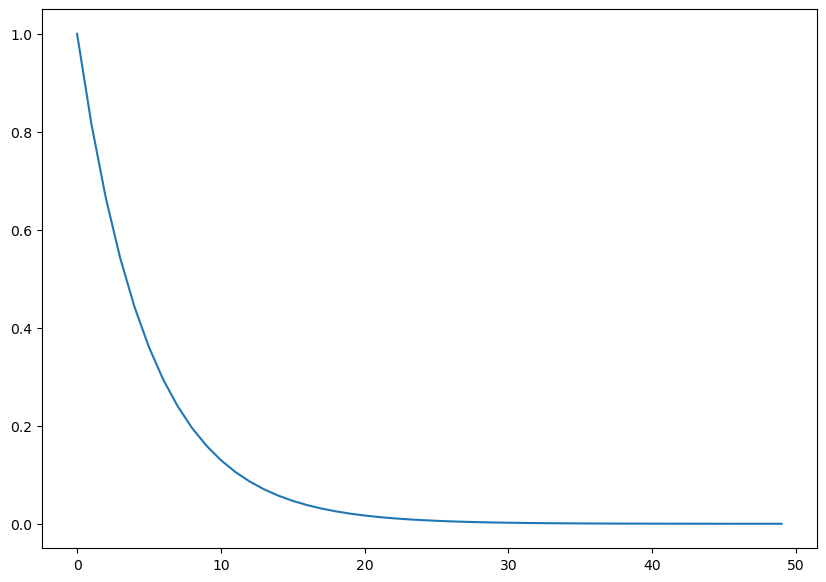

In [82]:
from scipy.stats import expon
x = np.linspace(0,10)
plt.figure(figsize=(10,7))
plt.plot(expon.pdf(x));

**Pretend** this is the distribution **we can't easily sample from!** Lets run the algorithm above.

Lets pick some random starting point:

In [83]:
num_steps = 1000
x = np.zeros(num_steps)
x[0] = 3   # random starting point

num_accepted = 0

for t in range(1, num_steps):
    # propose a new value
    proposed_x = x[t-1] + np.random.randn()
    
    # calculate its acceptance probability
    A = expon.pdf(proposed_x)/expon.pdf(x[t-1])
    A = np.amin([1,A])
    
    # accept it with that prob
    if np.random.rand() < A:    # accept
        x[t] = proposed_x
        num_accepted += 1
    else:                       # reject
        x[t] = x[t-1]

In [84]:
num_accepted/num_steps

0.554

And thats it! We ran our algorithm. Now to understand it! 

Lets first verify that indeed the histogram of our samples looks like the distribution we are trying to sample from! 

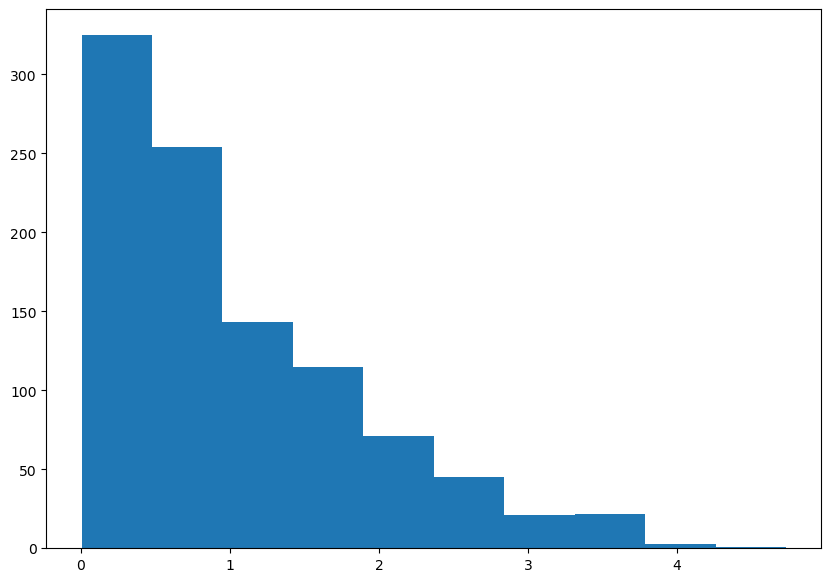

In [85]:
plt.figure(figsize=(10,7));
plt.hist(x,bins=10);

Perfect! Lets plot the **path** this chain took:

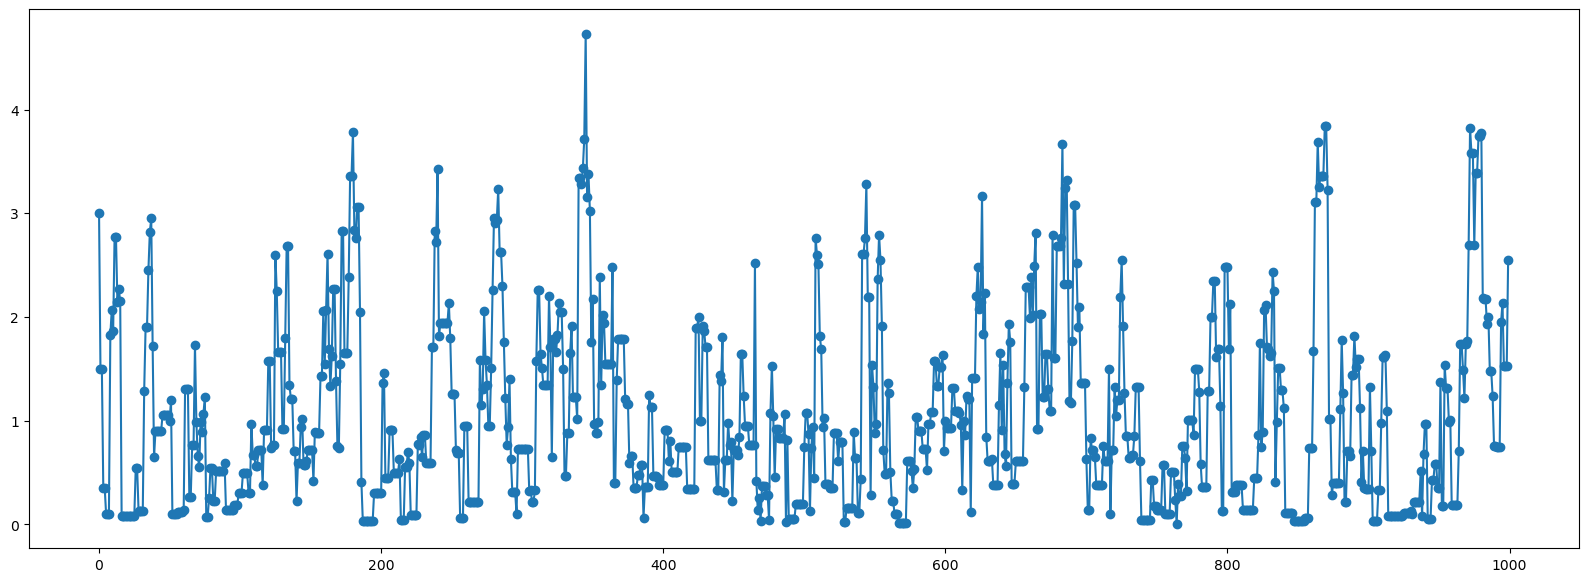

In [86]:
plt.figure(figsize=(20,7));
plt.plot(x,'-o');
# plt.scatter(range(len(x)),x);

<div class="info">

<font size="7">🤷🏽‍♂️</font>**Pause-and-ponder**: What are we looking at here? How is this related to the figure above? 
    
</div>

## MCMC for Bayesian Sampling

Recall, that in Bayesian statistics, we want to estimate the **posterior distribution**, but this is often **intractable** due to the **high-dimensional integral** in the **denominator (marginal likelihood)**.

$$
p(X|Y) = \frac{p(X)p(Y|X)}{p(Y)} = \frac{p(X)p(Y|X)}{\sum p(X_i)p(Y|X_i)}
$$


As we saw above when we discussed **Monte Carlo integration**, we can **approximate the posterior** $p(X|Y)$, if we can somehow **draw many samples that come from the posterior distribution**.

With vanilla Monte Carlo integration, we need the samples to be independent draws from the posterior distribution, **which is a problem** if we do not actually know what the posterior distribution is, **because we cannot integrate the marginal likelihood in the first place**!.

With MCMC, we draw samples from a **simple proposal distribution**, so that each draw depends **only on the state of the previous draw** (i.e. **the samples form a Markov chain!**). 

Under certain conditions, the Markov chain will have a **unique stationary distribution which will be posterior!** (Note: We have ignored those technical conditions in this document).

Note however, that **not all samples are used**! Instead we must set up **acceptance criteria** for each draw based on comparing successive states with respect to a **target distribution** that **ensure** that the **stationary distribution is the posterior distribution**! 

The nice thing is that this **target distribution** only needs to be **proportional to the posterior distribution**, which means we **don't need to evaluate the potentially intractable marginal likelihood!** (which is just the normalizing constant). 

We can find such a target distribution easily!

<div class="info">

<font size="7">🤷🏽‍♂️</font>**Pause-and-ponder**: Can you think of a distribution that is **proportional** to our posterior but easy to sample from?
    
</div>

If you suggested the **numerator** of Bayes rule, you are correct!

$$
p(X|Y) \propto p(X) P(Y|X)
$$

After some time, the Markov chain of **accepted draws** will **converge to the stationary distribution**, and we can use those samples as **correlated draws from the posterior distribution**, and find functions of the posterior distribution in the same way as for vanilla Monte Carlo integration.

Lets instantiate this problem with our favorite simple Bayesian example: the coin flips! 

We want to estimate the **bias of a coin** (the probability of flipping heads, say), **given** a sample consisting of $n$ tosses:

$$
p(\theta | X^n)
$$

where $X^n$ is all of our tosses. Note: we will drop the $(\cdot)^n$ notation below, as it is clear what we mean.

To compare our estimator, we can use a **beta distribution** as our **conjugate prior**, letting us write the posterior distribution in **closed form**

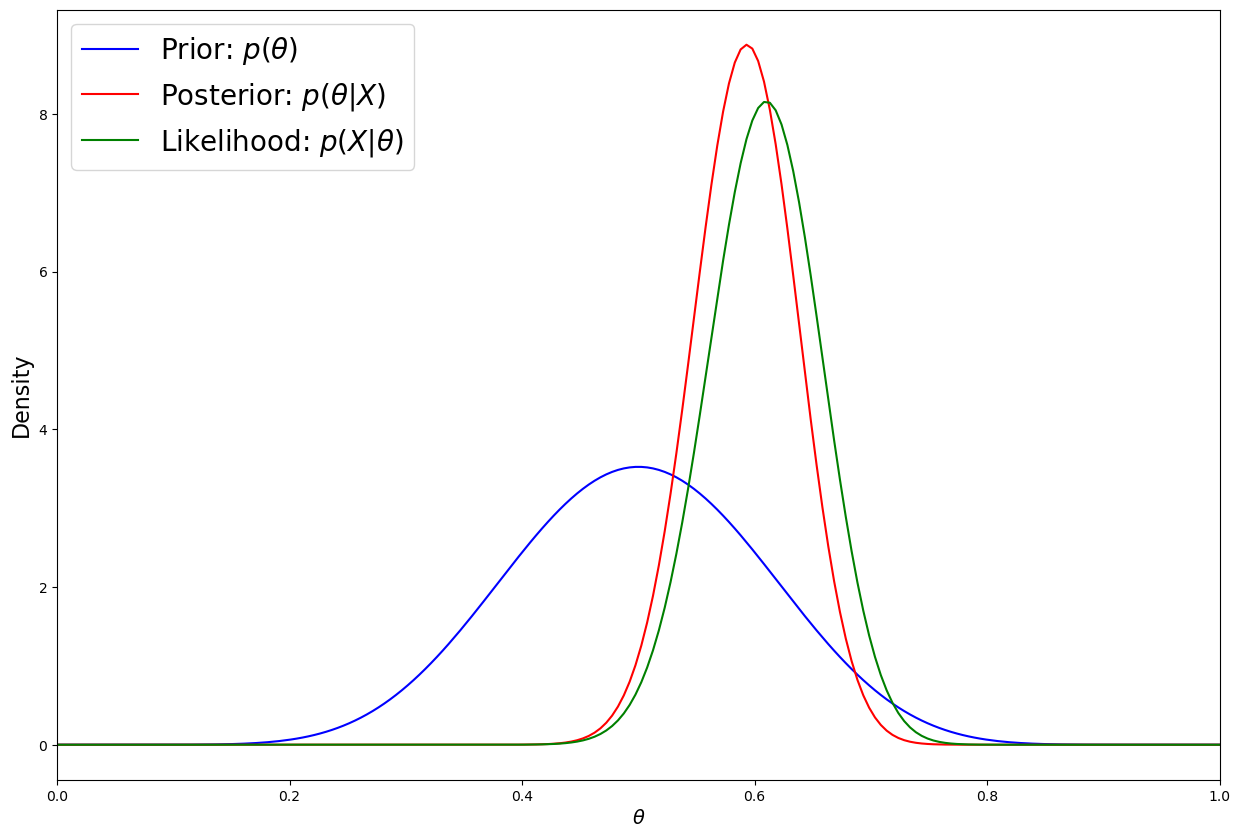

In [87]:
num_flips = 100
heads = 61
p = heads/num_flips

# setup distributions
thetas = np.linspace(0, 1, 200)

a, b = 10, 10
prior = stats.beta(a, b)
likelihood = stats.binom(num_flips, thetas)
post = stats.beta(heads+a, num_flips-heads+b)


plt.figure(figsize=(15,10))
plt.plot(thetas, prior.pdf(thetas), label=r'Prior: $p(\theta)$', c='blue')
plt.plot(thetas, post.pdf(thetas), label=r'Posterior: $p(\theta|X)$', c='red')
plt.plot(thetas, num_flips*likelihood.pmf(heads), label=r'Likelihood: $p(X|\theta)$', c='green')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=20);

Ok! Now we can **get sampling!**

Lets give the same **Metropolis Algorithm** above, in a **Bayesian** setting:

We first pick the same **"random walk" transition kernel/proposal distribution** as above:

$$
Q(y|x) = \mathcal{N}(x,1)
$$

To rewrite it in terms of our coin example, we have: 

$$
Q(\theta_p|\theta_t) = \mathcal{N}(\theta_t,\sigma)
$$

where $\sigma$ needs to be smaller than 1 (more on this below).

For the **target** distribution, one way to describe it is to think of our target distribution as the **actual posterior**: $\pi(\cdot) = \text{post}(\cdot)$. 

Take an initial guess for $\theta$, and proceed as follows:

 1. **propose** a new $\theta_p$: 
$$
\theta_p = \theta_t + \mathcal{N}(0,\sigma)
$$

 2. Calculate your **acceptance ratio**:
 
$$
A = \frac{\text{post}(\theta_p | X)}{\text{post}(\theta_t | X)}
$$


Before continuing, lets pause and think about this **acceptance ratio!** 


<div class="info">

<font size="7">🤷🏽‍♂️</font>**Pause-and-ponder**: What do you notice about this ratio?!
    
</div>

Indeed! The **model evidence/marginal likelihood cancels!** 

So we **do not** need to use the **actual posterior** in this ratio! Instead, we can any distribution that is **proportional to it!**. For example, **the Bayes numerator!**

Lets restate the algorithm now:

Take an initial guess for $\theta$, and proceed as follows:

 1. **propose** a new $\theta_p$: 
$$
\theta_p = \theta_t + \mathcal{N}(0,1)
$$

 2. Calculate your **acceptance ratio**:
 
$$
A = \frac{p(\theta_p) p(X|\theta_p)}{p(\theta_t) p(X|\theta_t)}
$$

 3. **With probability $A$**, **accept** the proposed value  and set $\theta_{t+1} = \theta_p$. Otherwise **reject it** and keep $\theta_{t+1} = \theta_t$. 

In [88]:
num_flips = 100
heads = 61

# setup distributions
a = 10
b = 10
likelihood = lambda curr_theta: stats.binom(num_flips, curr_theta).pmf(heads)
prior = lambda curr_theta: stats.beta(a, b).pdf(curr_theta)

num_accepted = 0

theta_0 = 0.1
num_steps = 10000
sigma = 0.3
samples = np.zeros(num_steps)
samples[0] = theta_0

for t in range(1,num_steps):
    # propose a theta
    theta_t = samples[t-1]
    theta_p = theta_t + np.random.randn()*sigma
    
    # calculate acceptance ratio
    A = (likelihood(theta_p)*prior(theta_p))/(likelihood(theta_t)*prior(theta_t))
    A = np.amin([1,A])
    
    # decice to accept:
    if np.random.rand() < A:
        samples[t] = theta_p
        num_accepted += 1
    else:
        samples[t] = theta_t
    
print("Efficiency = ", num_accepted/num_steps)

Efficiency =  0.1843


Woah! We only accepted very few of our proposed samples! 

Lets plot the histogram:

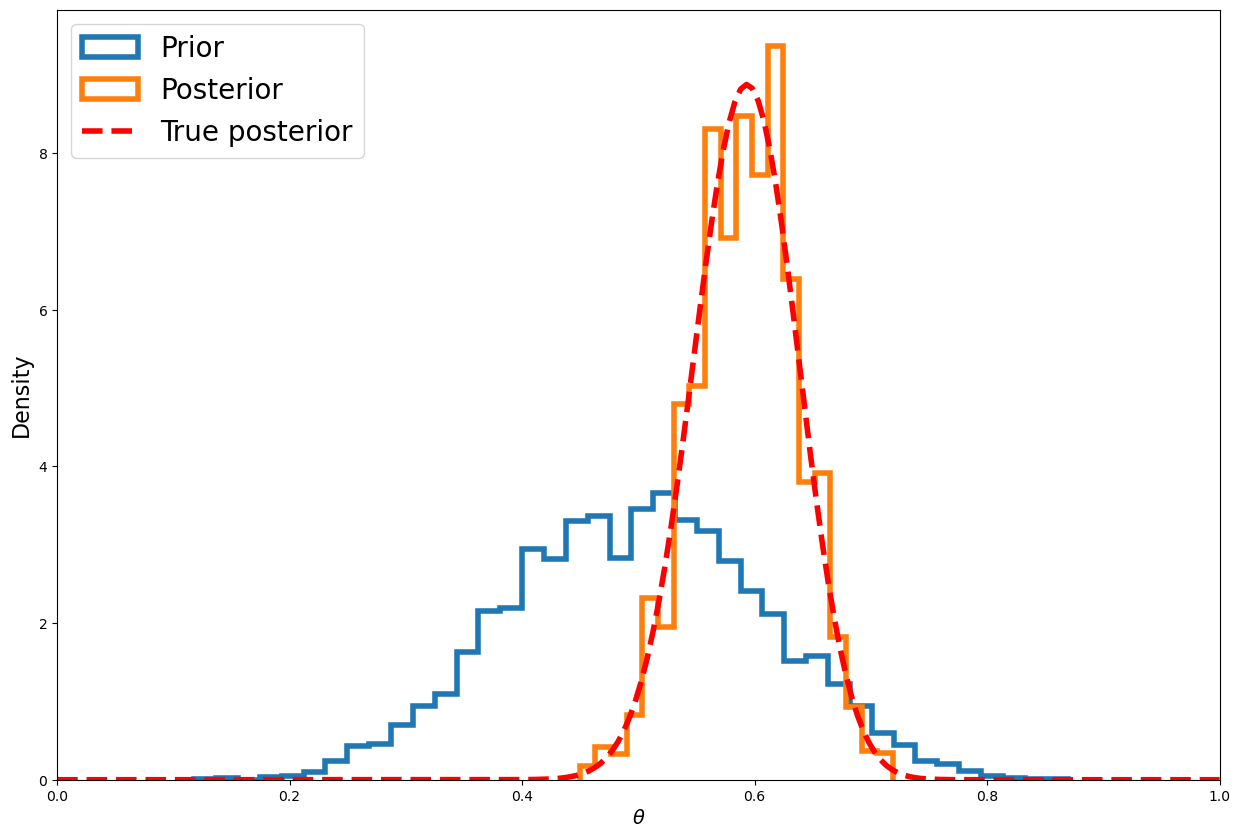

In [89]:
post = stats.beta(heads+a, num_flips-heads+b)

nmcmc = len(samples)//2

plt.figure(figsize=(15,10))
plt.hist(stats.beta(a, b).rvs(nmcmc), 40, histtype='step', density=True,linewidth=4, label='Prior');
plt.hist(samples[nmcmc:], 20, histtype='step', density=True, linewidth=4, label='Posterior');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', linewidth=4, label='True posterior')
plt.xlim([0,1]);
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=20);

As we did above, lets plot the path this chain took!

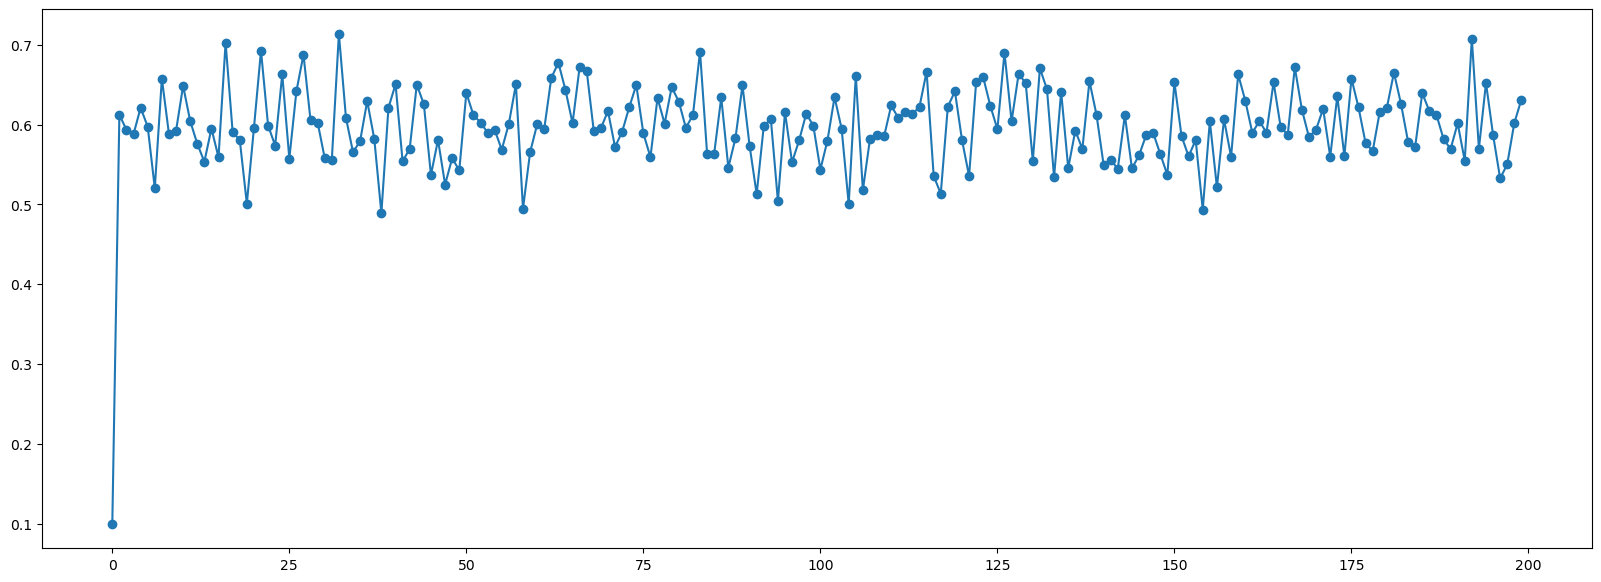

In [90]:
plt.figure(figsize=(20,7))
plt.plot(samples[::50], '-o');

These kinds of **trace plots** are often used to **informally** assess for **stochastic convergence**. 

This simple idea is just to run **multiple chains** and check that they converge to similar distributions. Lets repeat the above for multiple chains:

In [91]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)
    
def mh_coin(niters, n, h, theta, lik, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + stats.norm(0, sigma).rvs()
        rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
    return samples

In [92]:
num_flips = 100
heads = 61
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.05
num_iters = 100

sampless = [mh_coin(num_iters, num_flips, heads, theta, lik, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

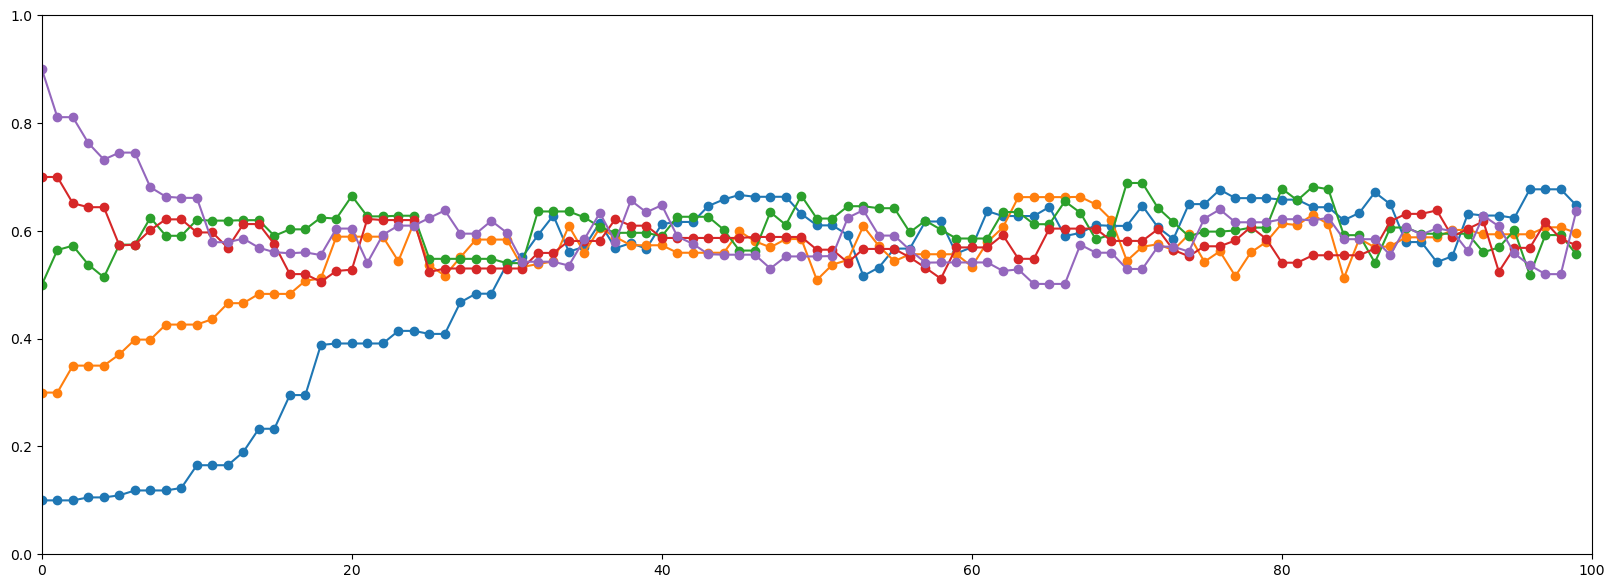

In [93]:
plt.figure(figsize=(20,7))
for samples in sampless:
    plt.plot(samples, '-o')
plt.xlim([0, num_iters])
plt.ylim([0, 1]);

<div class="info">

<font size="7">🧐</font>**Pause-and-ponder**: Debrief on what we've seen above. Questions to discuss:
    
 * Where exactly is the Markov Chain in MCMC?
 * Why does this chain sample from a distribution?
 * What can we say about the resulting samples? 
 * What about its efficiency?
 * What about how long it takes for the chain to "settle in" to a good setting? (also called **burn in**)
    
</div>

Above, we've described the **Metropolis Algorithm** for MCMC. There is also its natural extension the **Metropolis-Hastings Algorithm**, which changes the **acceptance ratio** formula, to account for **non-symmetric proposal distributions**. 

<div class="info">

<font size="7">🤷🏽‍♂️</font>**Pause-and-ponder**: Before looking it up, how do you think this will change the acceptance ratio?
    
</div>

---

## Gibbs Sampler
The other major MCMC algorithm is the **Gibbs Sampler**. This is a technique for construction a Markov Chain from a **join distribution**, by sampling from the **conditional distributions sequentially**! 

**Note**: For this part, I slightly modified the wording and code from this [really nice blog post!](https://mr-easy.github.io/2020-05-21-implementing-gibbs-sampling-in-python/).


Many times in the "real world" you will find yourself in a situation where it is **incredibly difficult** to sample from a **joint distribution**, but **much easier** to sample from a **conditional distribution**. 

The Gibbs sampler uses samples from the **conditional** distributions, to approximate samples from this joint!

Note: If its not, then we can also use Metropolis-Hastings to sample from this conditional, and then use Gibbs use to sample from the joint! This is called:

<center>Metropolis-Inside-Gibbs™<font size="6">😎</font></center>

The algorithm for the Gibbs sampler is actually very straightforward.

Suppose we have a **vector** of parameters $\theta=(\theta_1,\theta_2,\ldots,\theta_n)$, and we want to estimate the **joint** posterior distribution $p(\theta|X)$. 

Suppose we can find and draw random samples from all the conditional distributions:

$$
p(\theta_1 | \theta_2, \ldots, \theta_n,X) \\
p(\theta_2 | \theta_1, \ldots, \theta_n,X) \\
\cdots \\
p(\theta_n | \theta_1, \theta_2,\ldots,X) 
$$

With Gibbs sampling, the Markov chain is constructed by sampling from the conditional distribution **for each parameter $\theta_i$ in turn, treating all other parameters as observed**. 

When we have finished iterating over all parameters, we are said to have **completed one cycle of the Gibbs sampler**. 

Since hierarchical models are typically set up as products of conditional distributions, the Gibbs sampler is **ubiquitous in Bayesian modeling**. 

### Example Setup

Imagine we **want** to sample from a 2D Gaussian distribution over a variable of interest:

$$
\mathbf{X} = [x_0,x_1]^T \sim \mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})
$$

where:

$$
\mathbf{\mu} = 
\begin{bmatrix}
\mu_0 \\
\mu_1
\end{bmatrix} \quad\quad
\mathbf{\Sigma} = 
\begin{bmatrix}
\sigma_{00} & \sigma_{01} \\
\sigma_{10} & \sigma_{11} 
\end{bmatrix}
$$

This is our **target**, that we're pretending its **difficult** to sample from. 

The Gibbs sampler uses samples from the **conditional** distributions, to approximate samples from this joint.

In other words, we only need to sample from $p(x_0|x_1)$ and $p(x_1|x_0)$! 

Multivariate Gaussians have the property that the conditional distributions **are also Gaussian** (and the marginals too - for a proof of this property, see Wikipedia or any ML textbook). 

So our conditionals are given by:

$$
p(x_0|x_1) \sim \mathcal{N} \left(\mu_0 + \frac{\sigma_{01}}{\sigma_{11}}(x_1 -\mu_1),\sigma_{00} - \frac{\sigma_{01}^2}{\sigma_{11}}\right) \\
p(x_1|x_0) \sim \mathcal{N} \left(\mu_1 + \frac{\sigma_{01}}{\sigma_{00}}(x_0 -\mu_0),\sigma_{11} - \frac{\sigma_{01}^2}{\sigma_{00}}\right) 
$$

Wow these look verbose! But, they are just the formula's for 1D gaussians, in terms of the parameters of the 2D gaussian! Very simple to code up! 

Indeed: we give just one function that can simulate from both:

In [94]:
def conditional_sampler(sampling_index, current_x, mean, cov):
    conditioned_index = 1 - sampling_index 
    # The above line works because we only have 2 variables, x_0 & x_1
    a = cov[sampling_index, sampling_index]
    b = cov[sampling_index, conditioned_index]
    c = cov[conditioned_index, conditioned_index]
  
    mu = mean[sampling_index] + (b * (current_x[conditioned_index] - mean[conditioned_index]))/c
    sigma = np.sqrt(a-(b**2)/c)
    new_x = np.copy(current_x)
    new_x[sampling_index] = np.random.randn()*sigma + mu
    return new_x

Now we can give the actual Gibbs sampler for this problem:

In [95]:
def gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True):

    frames = []  # for GIF
    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2])  #sampled points
    samples[0] = point
    tmp_points = np.empty([num_samples, 2]) #inbetween points

    for i in range(num_samples):

        # Sample from p(x_0|x_1)
        point = conditional_sampler(0, point, mean, cov)
        tmp_points[i] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+1, tmp_points, i+1, title="Num Samples: " + str(i)))
            
        # Sample from p(x_1|x_0)
        point = conditional_sampler(1, point, mean, cov)
        samples[i+1] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+2, tmp_points, i+1, title="Num Samples: " + str(i+1)))
            
    if(create_gif):
        return samples, tmp_points, frames
    else:
        return samples, tmp_points

Now were ready to make some nice plots! Lets wrap up a lot of this ugly plotting code in functions:

---

#### Plotting code

In [102]:
# !pip install gif
from matplotlib.patches import Ellipse
import gif
import matplotlib.transforms as transforms
from IPython.display import Image

In [103]:
# plotting code from matplotlib and:
# https://github.com/mr-easy/Gibbs-Sampling-Visualized/blob/master/plotting_util.py
def plot_gaussian_from_points(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(x) != len(y):
        raise ValueError("x and y must be the same size")
    if len(x) < 2:
        raise ValueError("Need more data.")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_gaussian_from_parameters(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
	mean : array-like, shape (2, )
    	Mean vector
    cov : array-like, shape (2,2)
    	Covariance matrix
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(mean) != 2:
        raise ValueError("Mean vector length should be 2.")
    if (cov.shape != (2, 2)):
    	raise ValueError("Covariance should be a 2x2 matrix.")
    #checking if cov is symmetric pos semidefinite
    if(cov[0, 1] != cov[1, 0]):
        raise ValueError("Covariance should be symmetric.")
    if(cov[0, 0] < 0 or cov[0, 0]*cov[1,1] - cov[0,1]**2 < 0):
        raise ValueError("Covariance should be positive semidefinite.")

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [104]:
@gif.frame
def plot_samples(samples, num_samples, tmp_points, num_tmp, title="Gibbs Sampling", xlims=(-11, 11), ylims=(-11, 11)):
    fig = plt.figure(figsize=(15, 12))
    ax = fig.gca()
    
    # Plot the true distribution
    plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', alpha=0.5, label="True Distribution")
    
    # Plot sampled points
    ax.scatter(samples[:num_samples, 0], samples[:num_samples, 1], c='b', s=10, label="Sampled Points")
    ax.scatter(samples[0, 0], samples[0, 1], marker='*', c='g', s=60, label="Initial Point")
    
    # Plot samples from conditional distribution
    ax.scatter(tmp_points[:num_tmp, 0], tmp_points[:num_tmp, 1], c='r', alpha=0.4, s=5, label="Temporary Points")
    
    # Keeping the axes scales same for good GIFS
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    # Plot lines
    if(num_tmp > 0):
        ax.plot([samples[num_samples-1, 0], tmp_points[num_tmp-1, 0]], 
                [samples[num_samples-1, 1], tmp_points[num_tmp-1, 1]], c='k', alpha=0.25)
        
        # Plot estimated Gaussian, ignoring the starting point
        if(num_samples > 2):
            plot_gaussian_from_points(samples[1:num_samples, 0], samples[1:num_samples, 1], 
                                      ax, n_std=2, edgecolor='b', alpha=0.5, label=r"p(x_1|x_0)")
        # Plot estimated Gaussian, ignoring the starting point
        if(num_tmp > 2):
            plot_gaussian_from_points(tmp_points[1:num_tmp, 0], tmp_points[1:num_tmp, 1], 
                                      ax, n_std=2, edgecolor='r', alpha=0.5, label=r"p(x_0|x_1)")
    
    
    ax.legend(loc='upper left',fontsize=22)
    ax.set_title(title,fontsize=22)

---

### Resume Example

Ok! After all that plotting setup, we can actually run our example!

Lets specify the **true distribution**:

In [105]:
mean = np.array([0, 0])
cov = np.array([[10, 3], 
                [3, 5]])

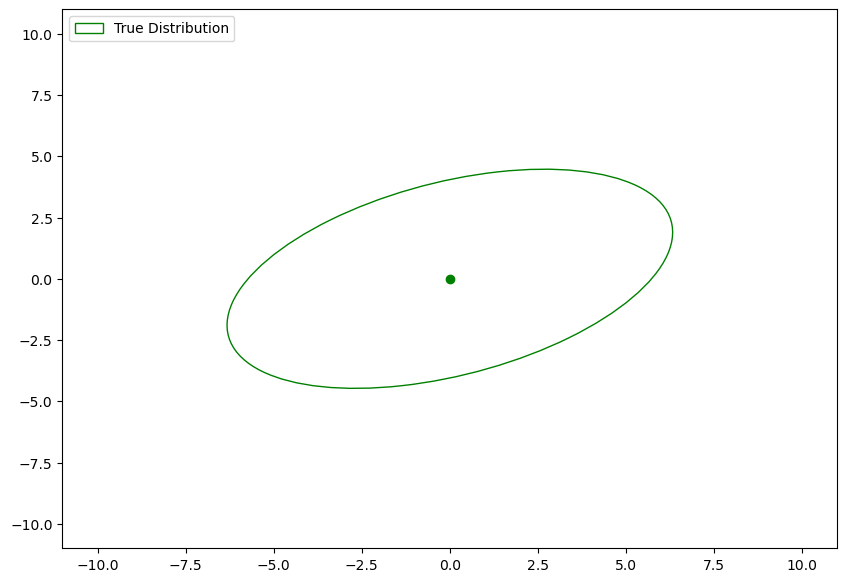

In [106]:
# Plot true distribution
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', label="True Distribution")
ax.scatter(mean[0], mean[1], c='g')
ax.set_xlim((-11, 11))
ax.set_ylim((-11, 11))
ax.legend(loc='upper left');

This is the distribution we want to **sample from**.

Lets run our Gibbs sampler:

In [107]:
initial_point = [-9.0, -9.0]
num_samples = 100
samples, tmp_points, frames = gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True)

Now lets create the gif so we can visualize it! 

In [110]:
# Creating the GIF
if reanimate_gifs:
    gif.save(frames, "gibbs.gif", duration=150)

![](gibbs.gif)

<div class="info">

<font size="7">🧐</font>**Pause-and-ponder**: Whoa! Lets break this down and discuss!
    
</div>

# Resources 

* https://setosa.io/ev/markov-chains/ - I took an example and some language from this great site! 
* The explanation of MC estimation was taken from its wikipedia page, and: 
  * https://cs.dartmouth.edu/~wjarosz/publications/dissertation/appendixA.pdf
  * http://people.duke.edu/~ccc14/sta-663-2017/20A_MCMC.html
* The Gibbs sampler code and example was taken from:
  * https://mr-easy.github.io/2020-05-21-implementing-gibbs-sampling-in-python/